# Импорты

In [16]:
from collections.abc import Iterable
from typing import Any

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, KFold, ParameterGrid, train_test_split
from sklearn.pipeline import FunctionTransformer, Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from tqdm import tqdm
import seaborn as sns
import dataframe_image as dfi

from src import business, modeling, transforms, vis
from src.const import DATA_PATH, DATA_TEST_PATH, TARGET, DATA_TEST_TARGETS_PATH

# Для более качественных графиков
%config InlineBackend.figure_format='retina'
plt.rcParams["figure.dpi"] = 150
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Датасет

### Загрузить в pandas

In [2]:
loan_data = pd.read_csv(DATA_PATH)
loan_data.head(2)

,лимит_нарушен,пол,тип,цель,кредитоспособность,другие_кредиты,бизнес,сумма,сбор,срок,...,один_платеж,стоимость_имущества,проживание,тип_залога,тип_кредита,кредитный_рейтинг,возраст,прямой_залог,дефолт,речь
0,0.0,м,3.0,0.0,1.0,NaN,0.0,174765.264968,normal,245.885949,...,0.0,244488.111841,осн,дом,2.0,709.508335,55-64,1.0,0,"""Hey there! I’m a guy with a solid job and a m..."
1,0.0,NaN,NaN,0.0,1.0,0.0,0.0,NaN,want,365.885949,...,0.0,NaN,осн,дом,1.0,722.508335,55-64,NaN,0,"""Hi there! We are a couple with a solid financ..."


In [22]:
dfi.export(loan_data, "imgs/load_data.png", max_rows=10)

In [6]:
loan_test_data = pd.read_csv("data/load_data_test.csv")
loan_test_data.head(2)

,ID,лимит_нарушен,пол,тип,цель,кредитоспособность,другие_кредиты,бизнес,сумма,сбор,...,только_процент,один_платеж,стоимость_имущества,проживание,тип_залога,тип_кредита,кредитный_рейтинг,возраст,прямой_залог,речь
0,d61968aa-7fb8-46b2-8573-3d101d3ebe5b,1.0,м,NaN,1.0,1.0,0.0,NaN,154765.264968,routine,...,NaN,0.0,224488.111841,инвест,дом,2.0,783.508335,35-44,1.0,"""My name's Tom, and I'm working in marketing w..."
1,760116cf-25b4-47aa-9a20-e3baa5fc6d09,0.0,NaN,NaN,NaN,1.0,0.0,1.0,434765.264968,normal,...,0.0,0.0,NaN,осн,дом,NaN,568.508335,25-34,1.0,"""Hi! We’re a couple with a comfortable income,..."


In [32]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   лимит_нарушен        6462 non-null   float64
 1   пол                  3778 non-null   object 
 2   тип                  6466 non-null   float64
 3   цель                 6442 non-null   float64
 4   кредитоспособность   6406 non-null   float64
 5   другие_кредиты       6425 non-null   float64
 6   бизнес               6369 non-null   float64
 7   сумма                6414 non-null   float64
 8   сбор                 8000 non-null   object 
 9   срок                 6376 non-null   float64
 10  амортизация          6338 non-null   float64
 11  только_процент       6435 non-null   float64
 12  один_платеж          6396 non-null   float64
 13  стоимость_имущества  5790 non-null   float64
 14  проживание           8000 non-null   object 
 15  тип_залога           8000 non-null   o

In [33]:
loan_data.describe()

,лимит_нарушен,тип,цель,кредитоспособность,другие_кредиты,бизнес,сумма,срок,амортизация,только_процент,один_платеж,стоимость_имущества,тип_кредита,кредитный_рейтинг,прямой_залог,дефолт
count,6462.000000,6466.000000,6442.000000,6406.00000,6425.000000,6369.000000,6.414000e+03,6376.000000,6338.000000,6435.000000,6396.000000,5.790000e+03,6340.000000,6386.000000,6420.000000,8000.000000
mean,0.065305,2.664089,1.118131,0.96113,0.004669,0.134715,3.484416e+05,340.620736,0.101925,0.050971,0.019856,5.386556e+05,2.148580,710.309933,0.999844,0.236750
std,0.247082,0.653671,1.138390,0.19330,0.068178,0.341446,1.842944e+05,59.079085,0.302573,0.219956,0.139517,3.607842e+05,0.986423,115.213366,0.012481,0.425114
min,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,4.476526e+04,101.885949,0.000000,0.000000,0.000000,7.448811e+04,1.000000,511.508335,0.000000,0.000000
25%,0.000000,3.000000,0.000000,1.00000,0.000000,0.000000,2.147653e+05,365.885949,0.000000,0.000000,0.000000,3.144881e+05,1.000000,611.508335,1.000000,0.000000
50%,0.000000,3.000000,1.000000,1.00000,0.000000,0.000000,3.147653e+05,365.885949,0.000000,0.000000,0.000000,4.544881e+05,2.000000,708.508335,1.000000,0.000000
75%,0.000000,3.000000,2.000000,1.00000,0.000000,0.000000,4.522653e+05,365.885949,0.000000,0.000000,0.000000,6.644881e+05,3.000000,810.508335,1.000000,0.000000
max,1.000000,3.000000,3.000000,1.00000,1.000000,1.000000,3.024765e+06,365.885949,1.000000,1.000000,1.000000,4.914488e+06,4.000000,911.508335,1.000000,1.000000


### Разделить на числовые и категориальные

In [7]:
from src.features import categorical_features, numeric_features, others

In [6]:
loan_data[numeric_features]

,срок,стоимость_имущества,кредитный_рейтинг,сумма
0,245.885949,244488.111841,709.508335,174765.264968
1,365.885949,NaN,722.508335,NaN
2,365.885949,364488.111841,785.508335,NaN
3,365.885949,894488.111841,594.508335,474765.264968
4,365.885949,504488.111841,589.508335,384765.264968
...,...,...,...,...
7995,125.885949,744488.111841,NaN,NaN
7996,185.885949,184488.111841,796.508335,NaN
7997,365.885949,NaN,584.508335,394765.264968
7998,365.885949,NaN,873.508335,594765.264968


### Наличие аномалий

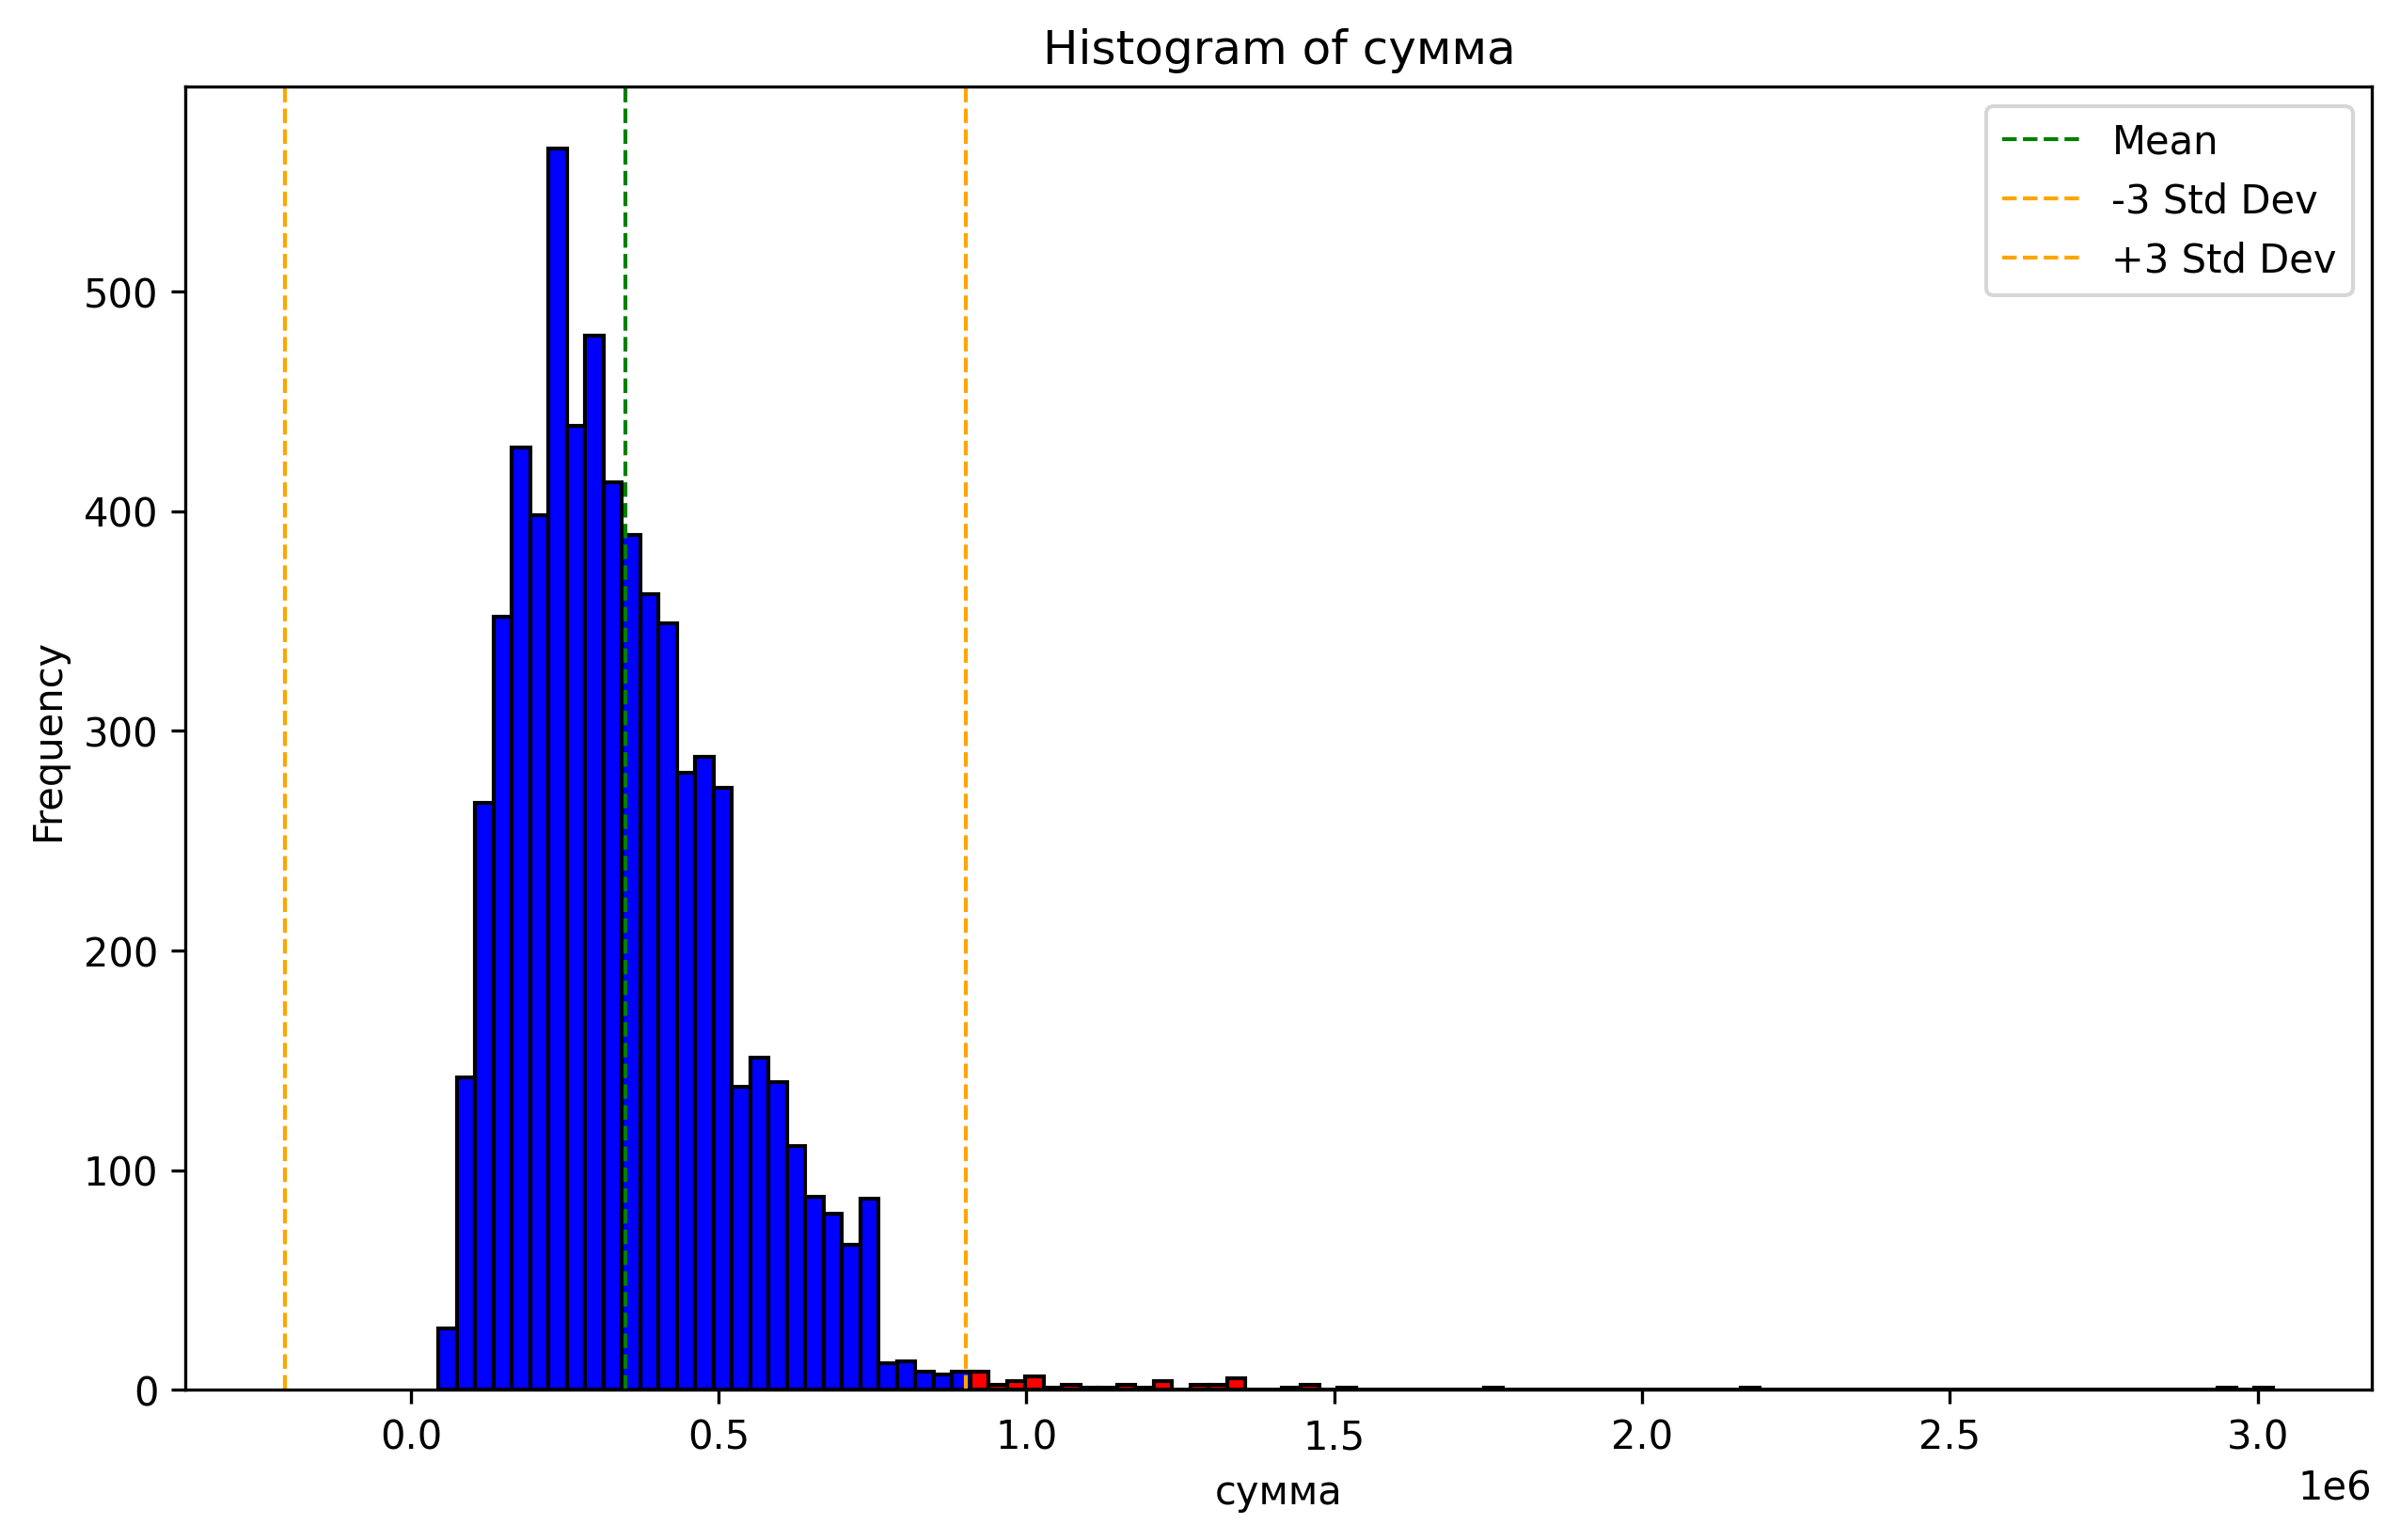

In [7]:
vis.plot_anomalies(loan_data, ["сумма"])

<Axes: xlabel='сумма'>

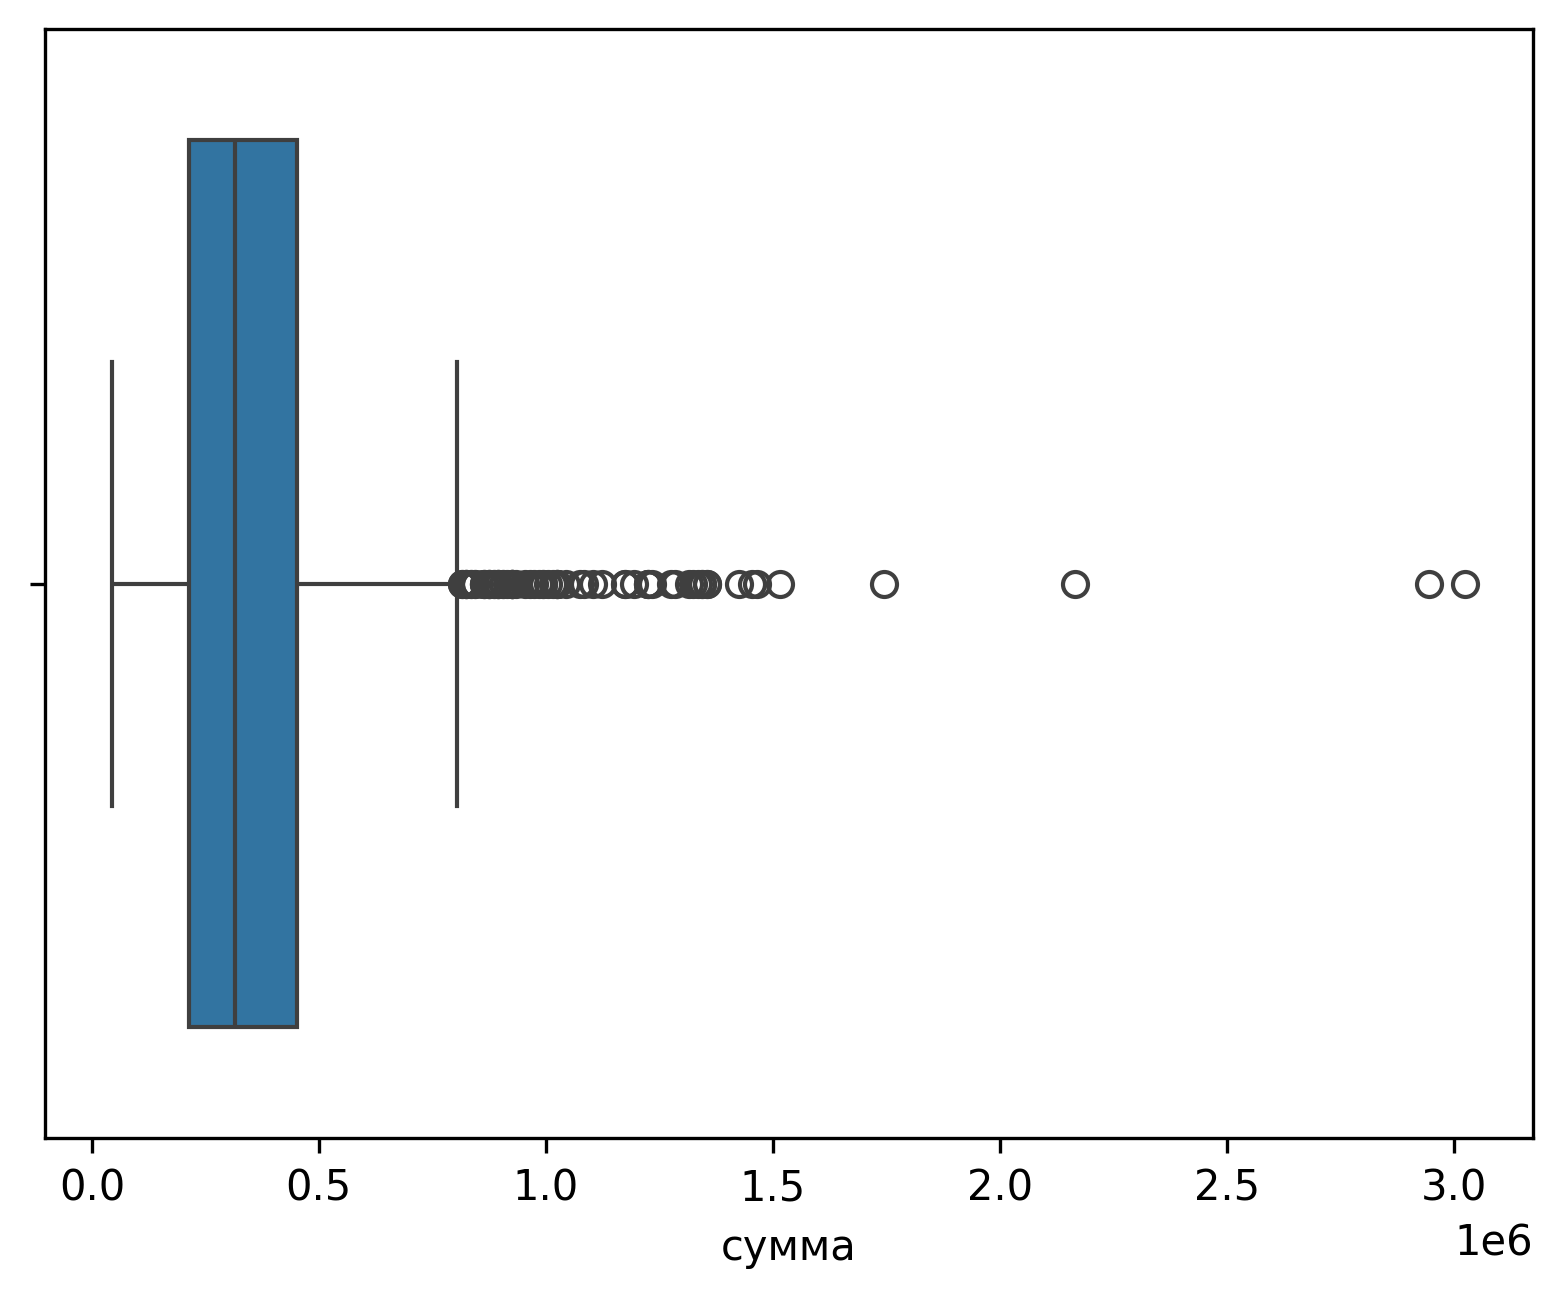

In [31]:
sns.boxplot(x=loan_data["сумма"])

In [9]:
numeric_features

['срок', 'стоимость_имущества', 'кредитный_рейтинг', 'сумма']

<Axes: xlabel='стоимость_имущества', ylabel='дефолт'>

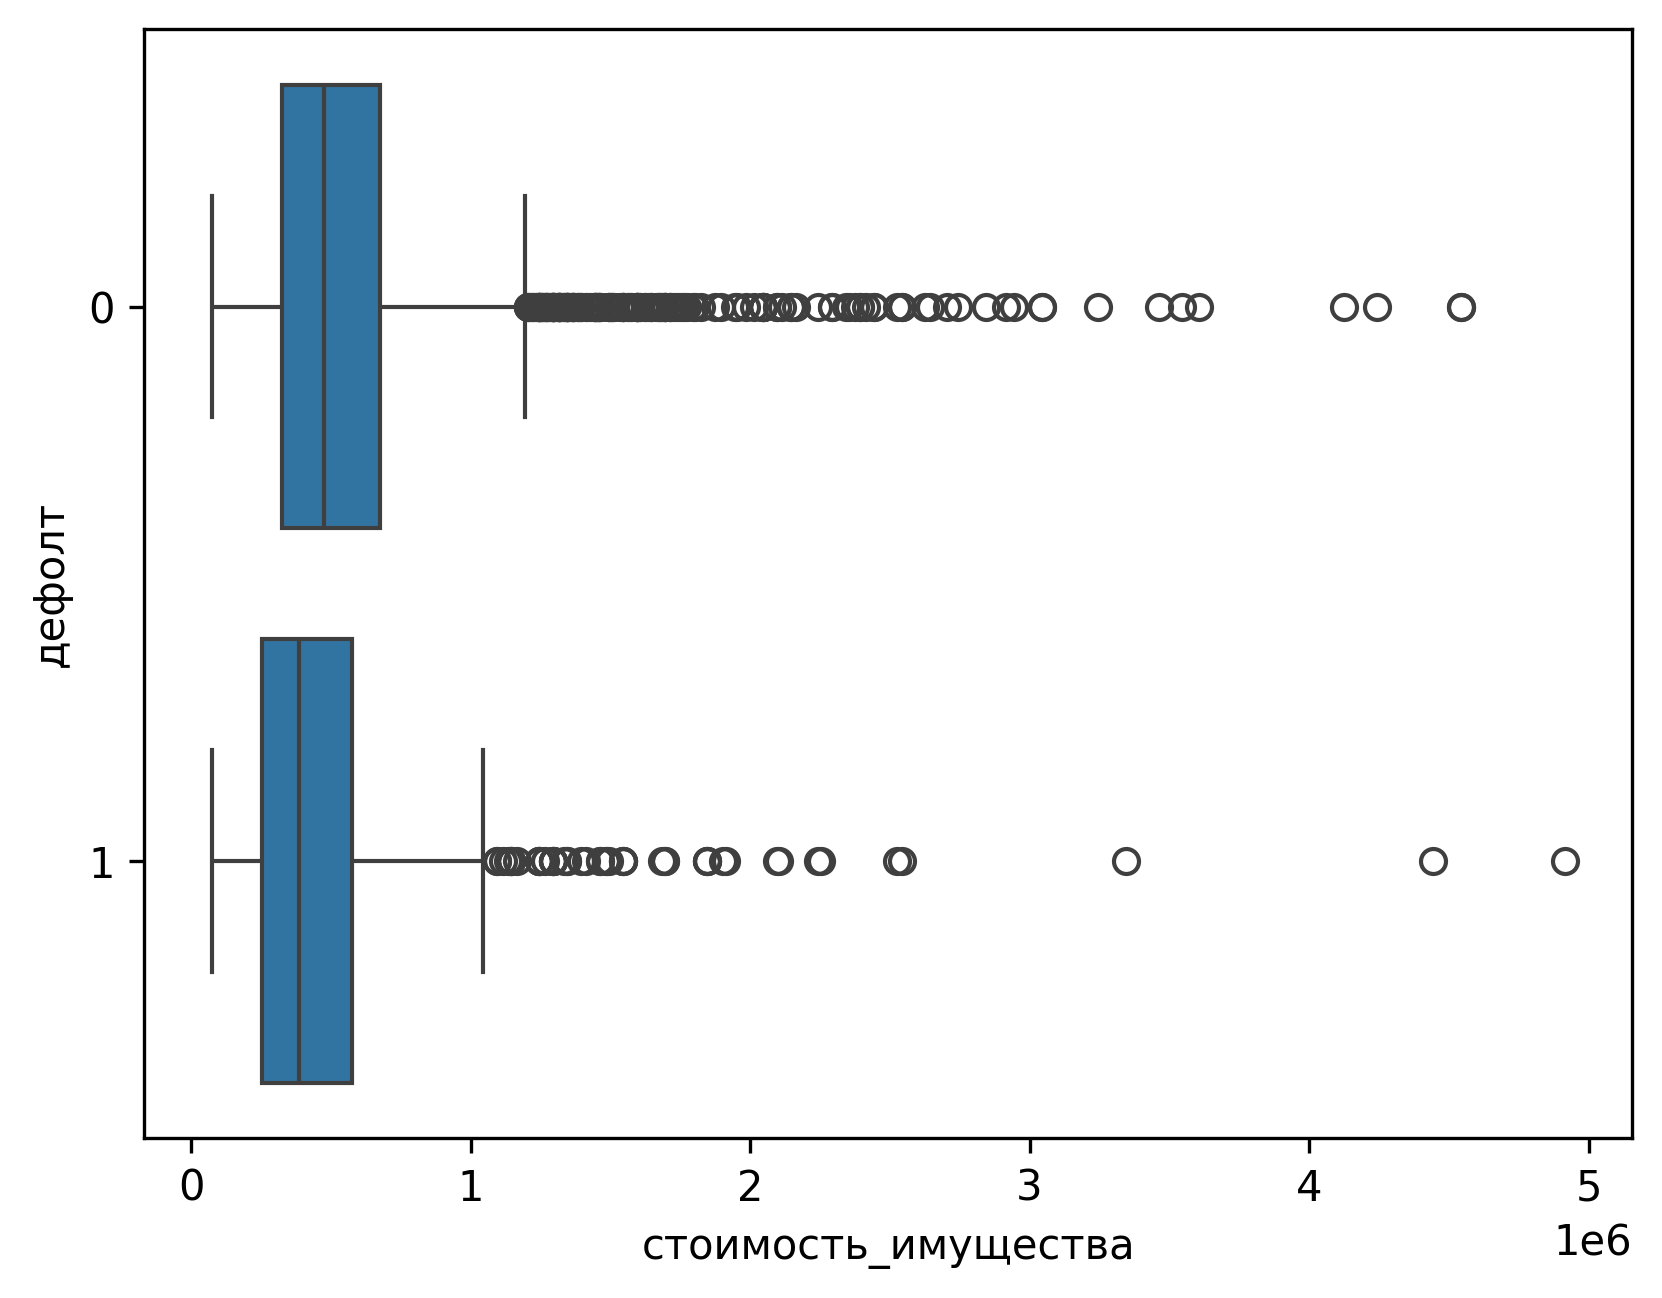

In [15]:
sns.boxplot(x=loan_data["стоимость_имущества"], y=loan_data[TARGET].astype("category"))

### Заменить аномальные значения

In [8]:
# Добавить в пайп модели

clipper = FunctionTransformer(transforms.clip_anomalies, kw_args={"cols": ["сумма"]})
pipe = make_pipeline(clipper)
pipe

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function clip_anomalies at 0x0000015A38966700>,
                                     kw_args={'cols': ['сумма']}))])

In [9]:
transforms.clip_anomalies(loan_data, cols=["сумма"]).head(2)

,лимит_нарушен,пол,тип,цель,кредитоспособность,другие_кредиты,бизнес,сумма,сбор,срок,...,один_платеж,стоимость_имущества,проживание,тип_залога,тип_кредита,кредитный_рейтинг,возраст,прямой_залог,дефолт,речь
0,0.0,м,3.0,0.0,1.0,NaN,0.0,174765.264968,normal,245.885949,...,0.0,244488.111841,осн,дом,2.0,709.508335,55-64,1.0,0,"""Hey there! I’m a guy with a solid job and a m..."
1,0.0,NaN,NaN,0.0,1.0,0.0,0.0,NaN,want,365.885949,...,0.0,NaN,осн,дом,1.0,722.508335,55-64,NaN,0,"""Hi there! We are a couple with a solid financ..."


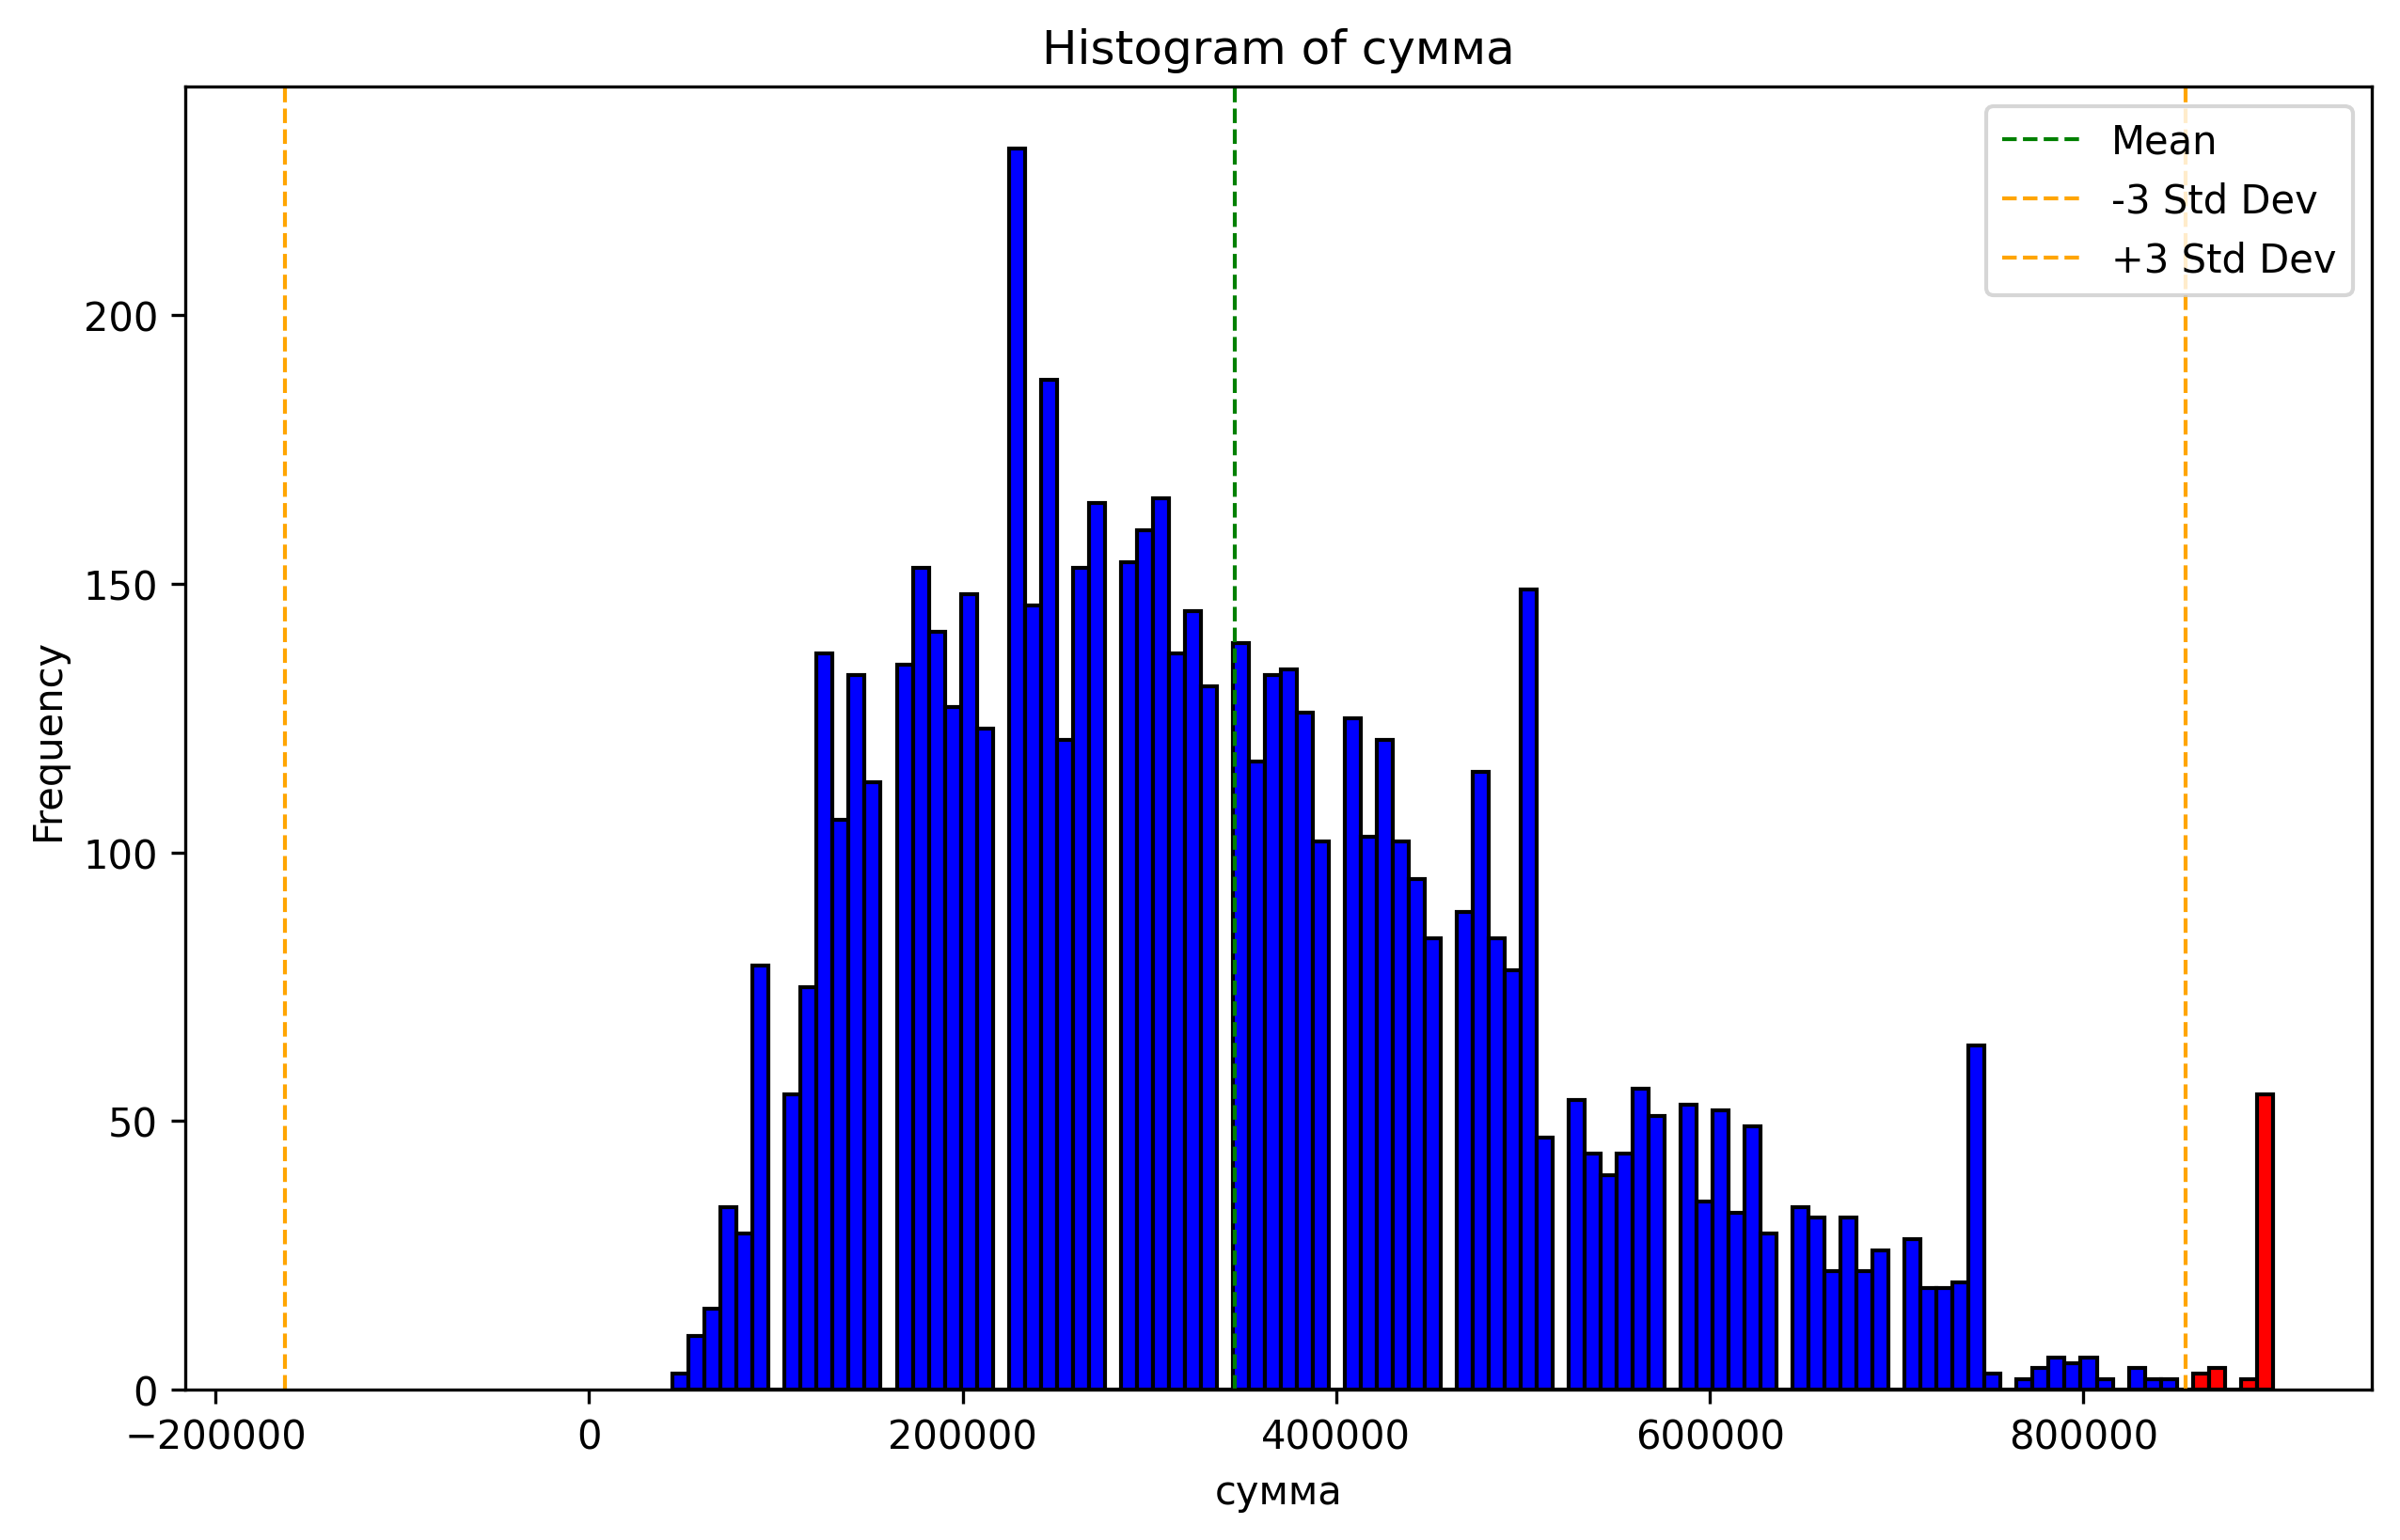

In [10]:
# Vis
cols = ["сумма"]
vis.plot_anomalies(transforms.clip_anomalies(loan_data, cols), cols)

### Убрать аномальные значения

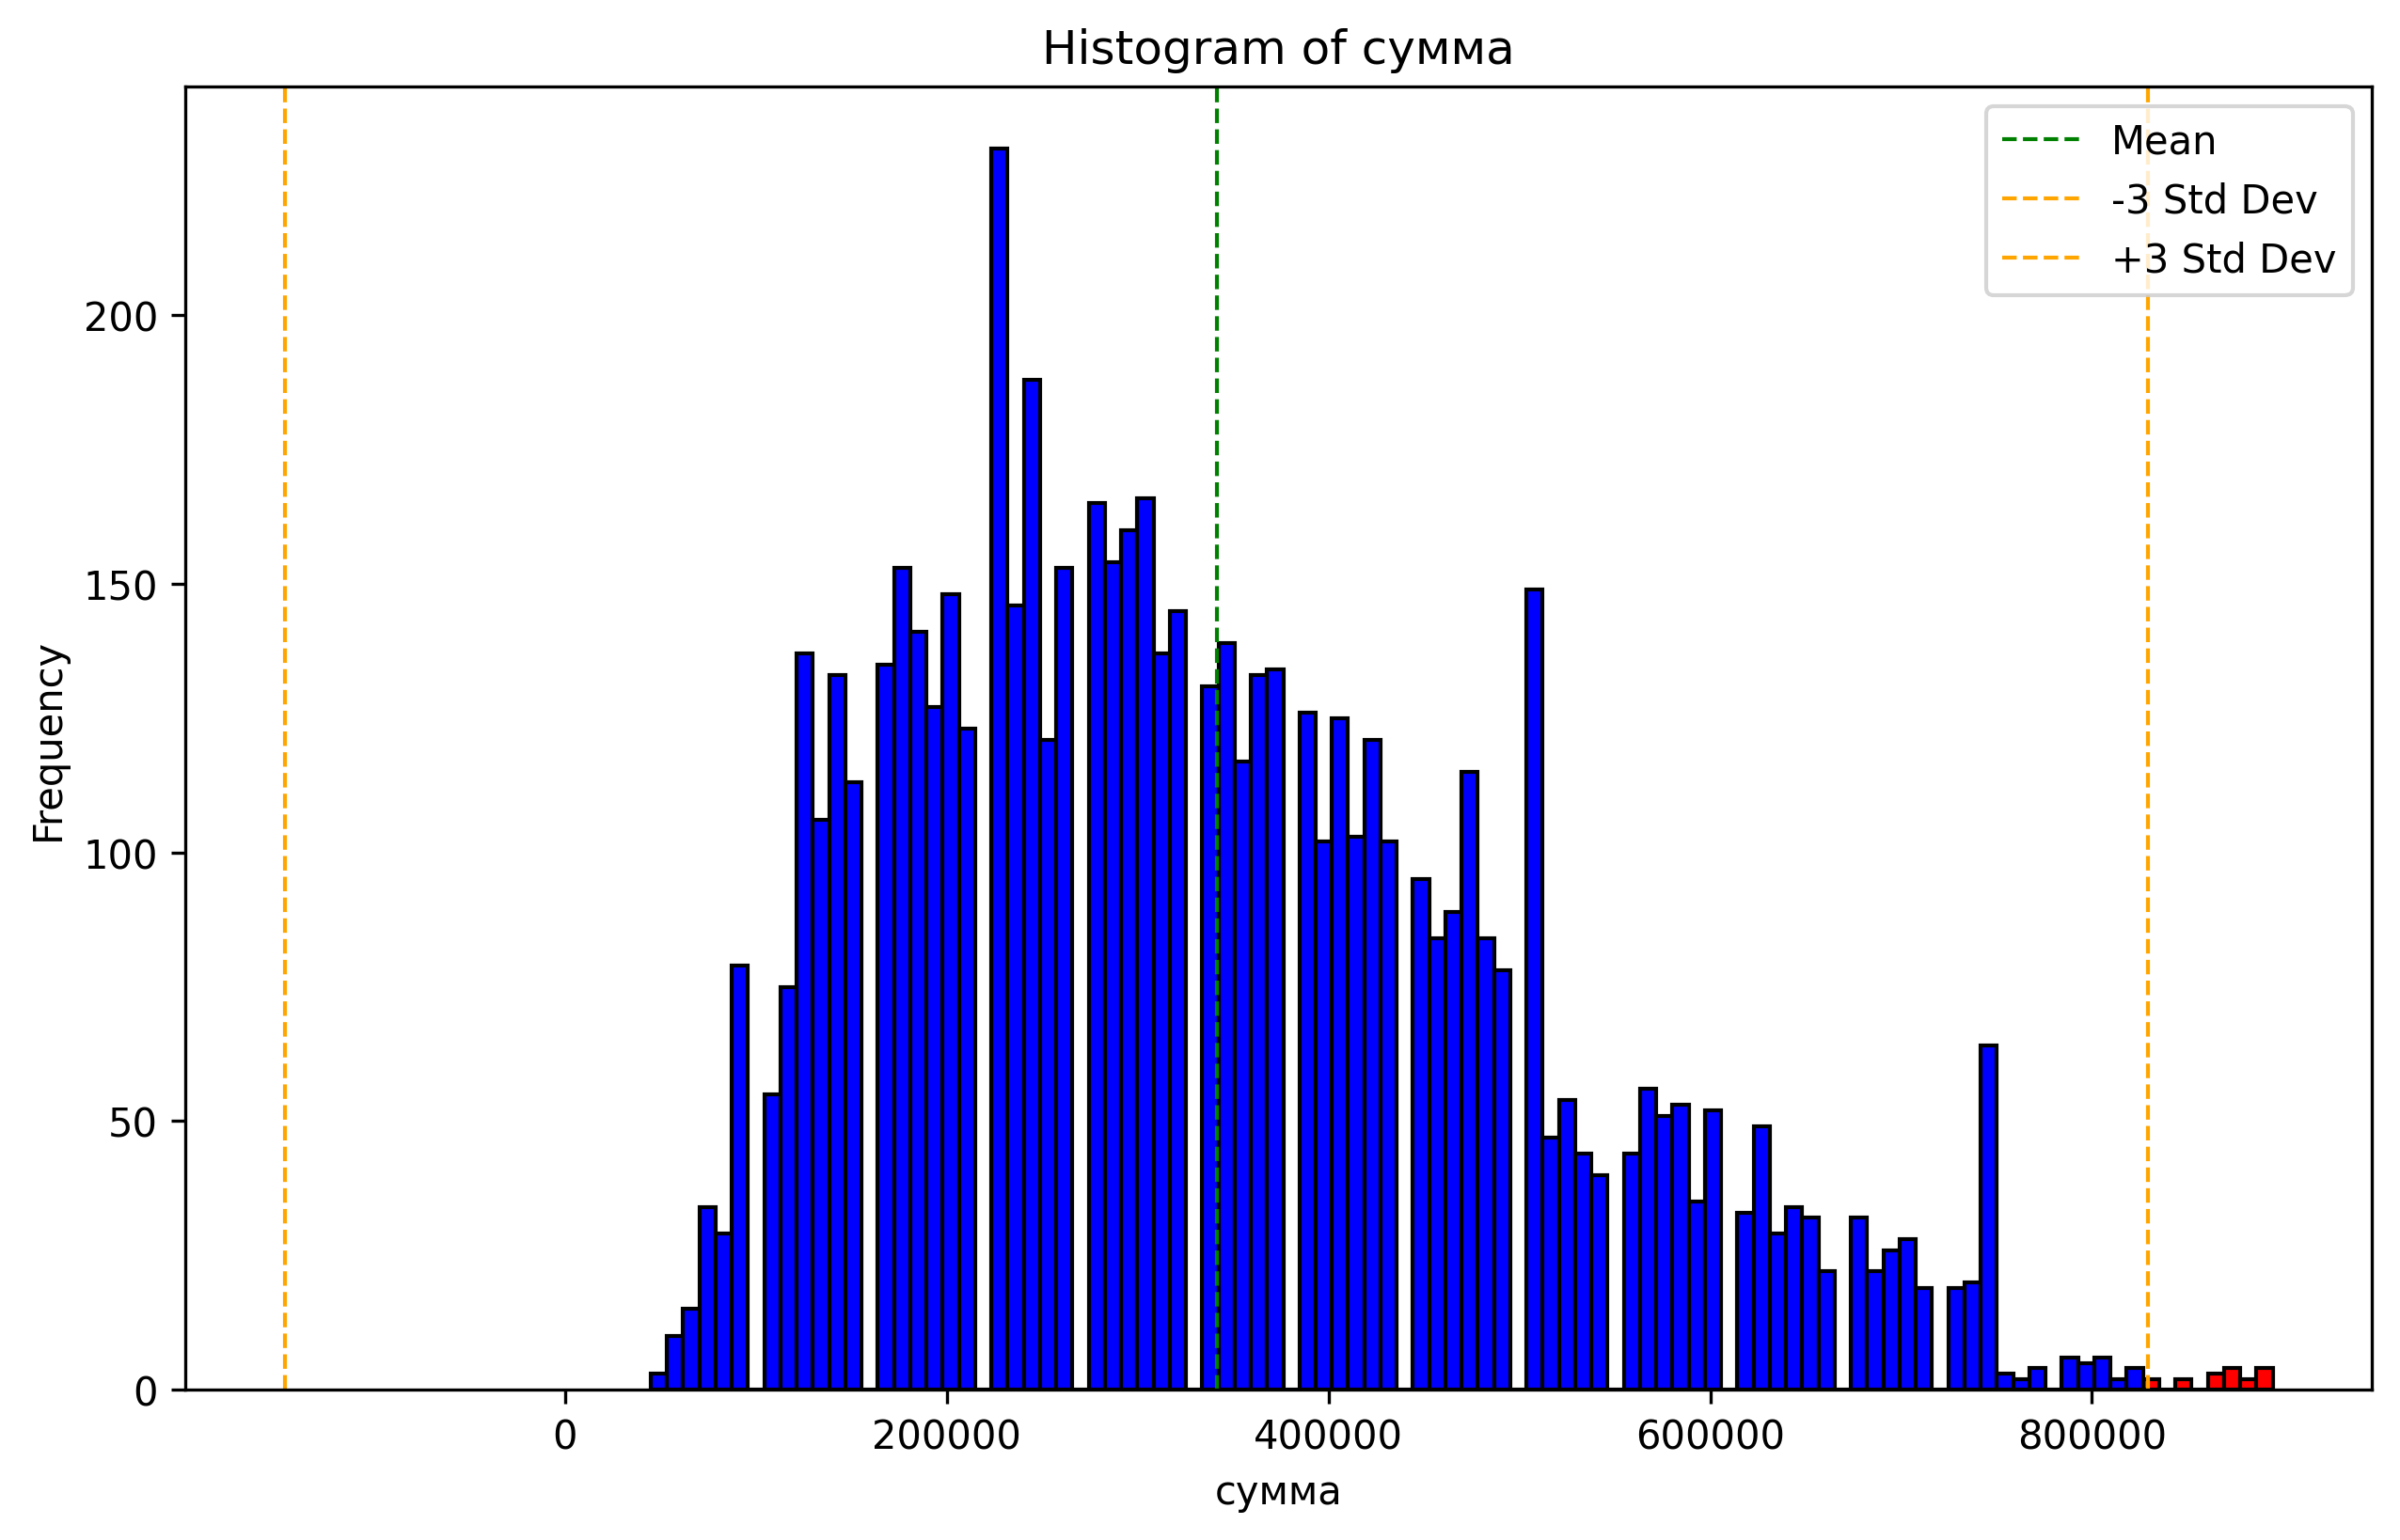

In [11]:
# В пайпе нельзя юзать

# Vis
cols = ["сумма"]

vis.plot_anomalies(transforms.remove_anomalies(loan_data, cols), cols)

### Построить гистограммы

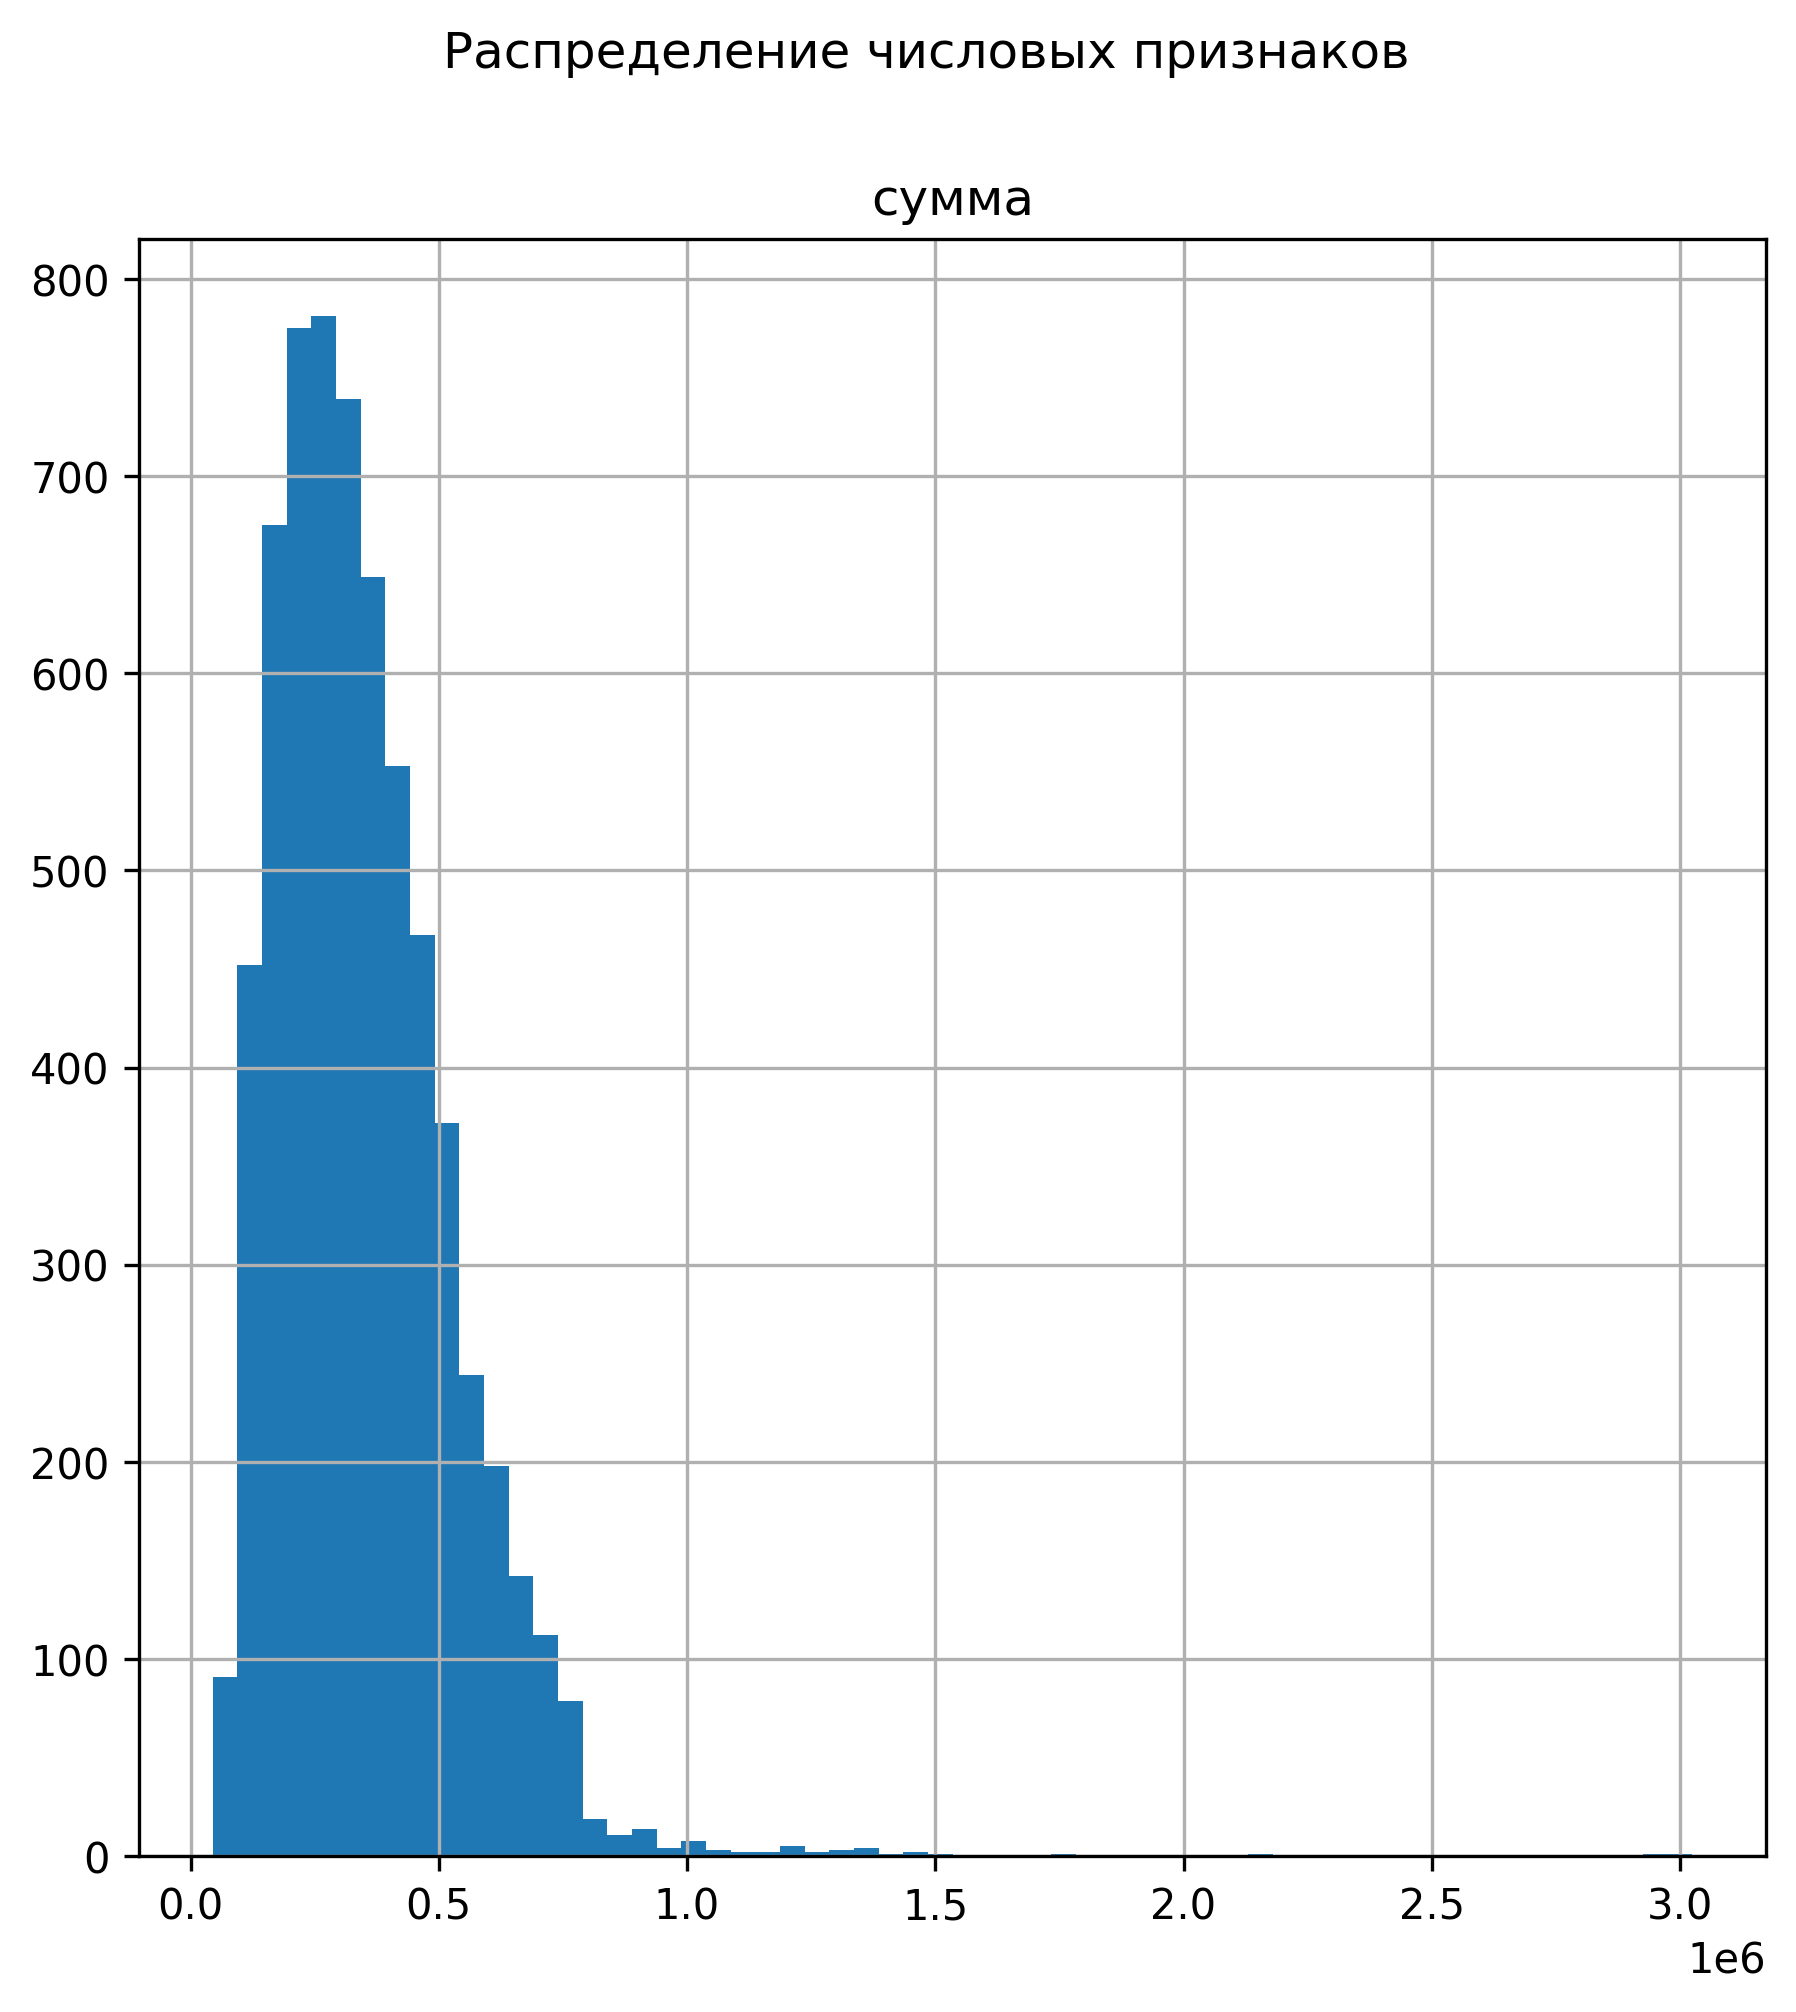

In [12]:
vis.plot_hist(loan_data, ["сумма"])

### Построить корреляционную матрицу

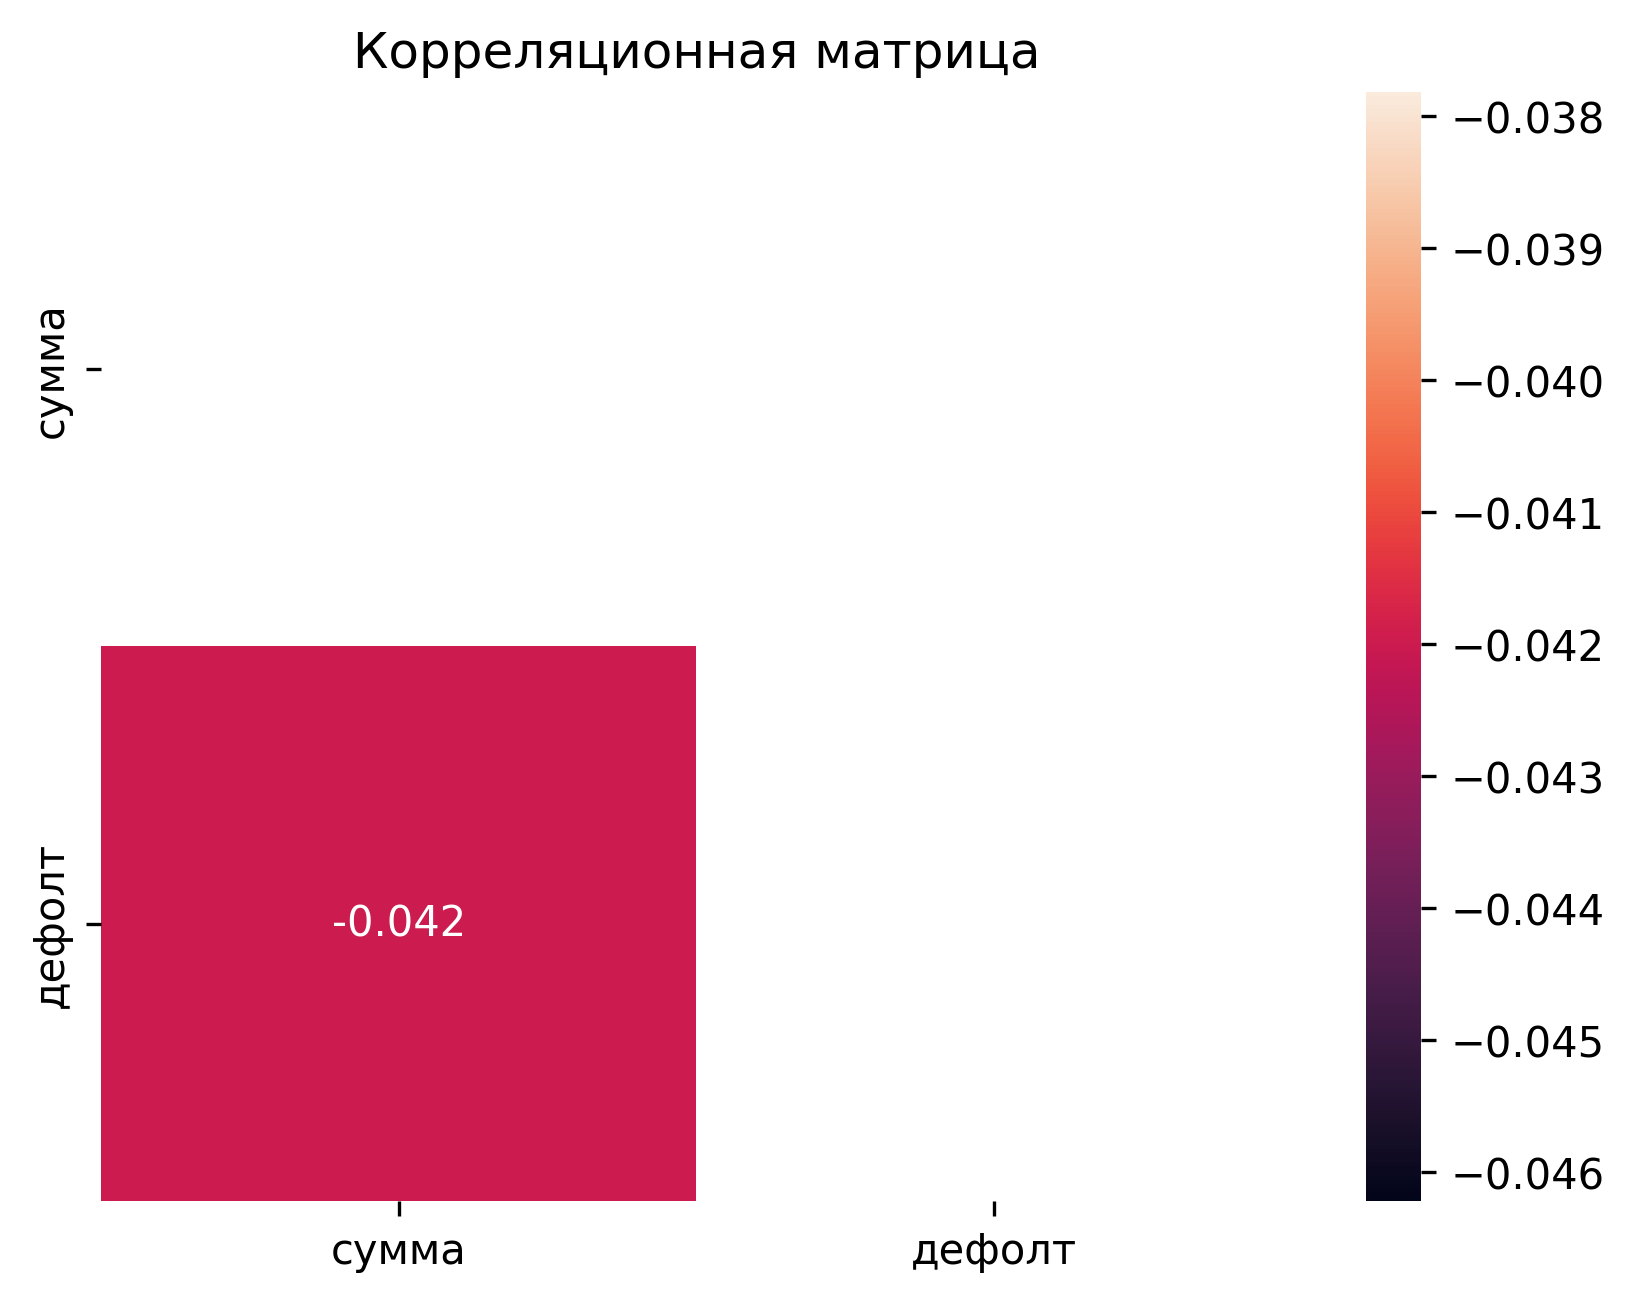

In [13]:
vis.plot_corr(loan_data, ["сумма", "дефолт"])

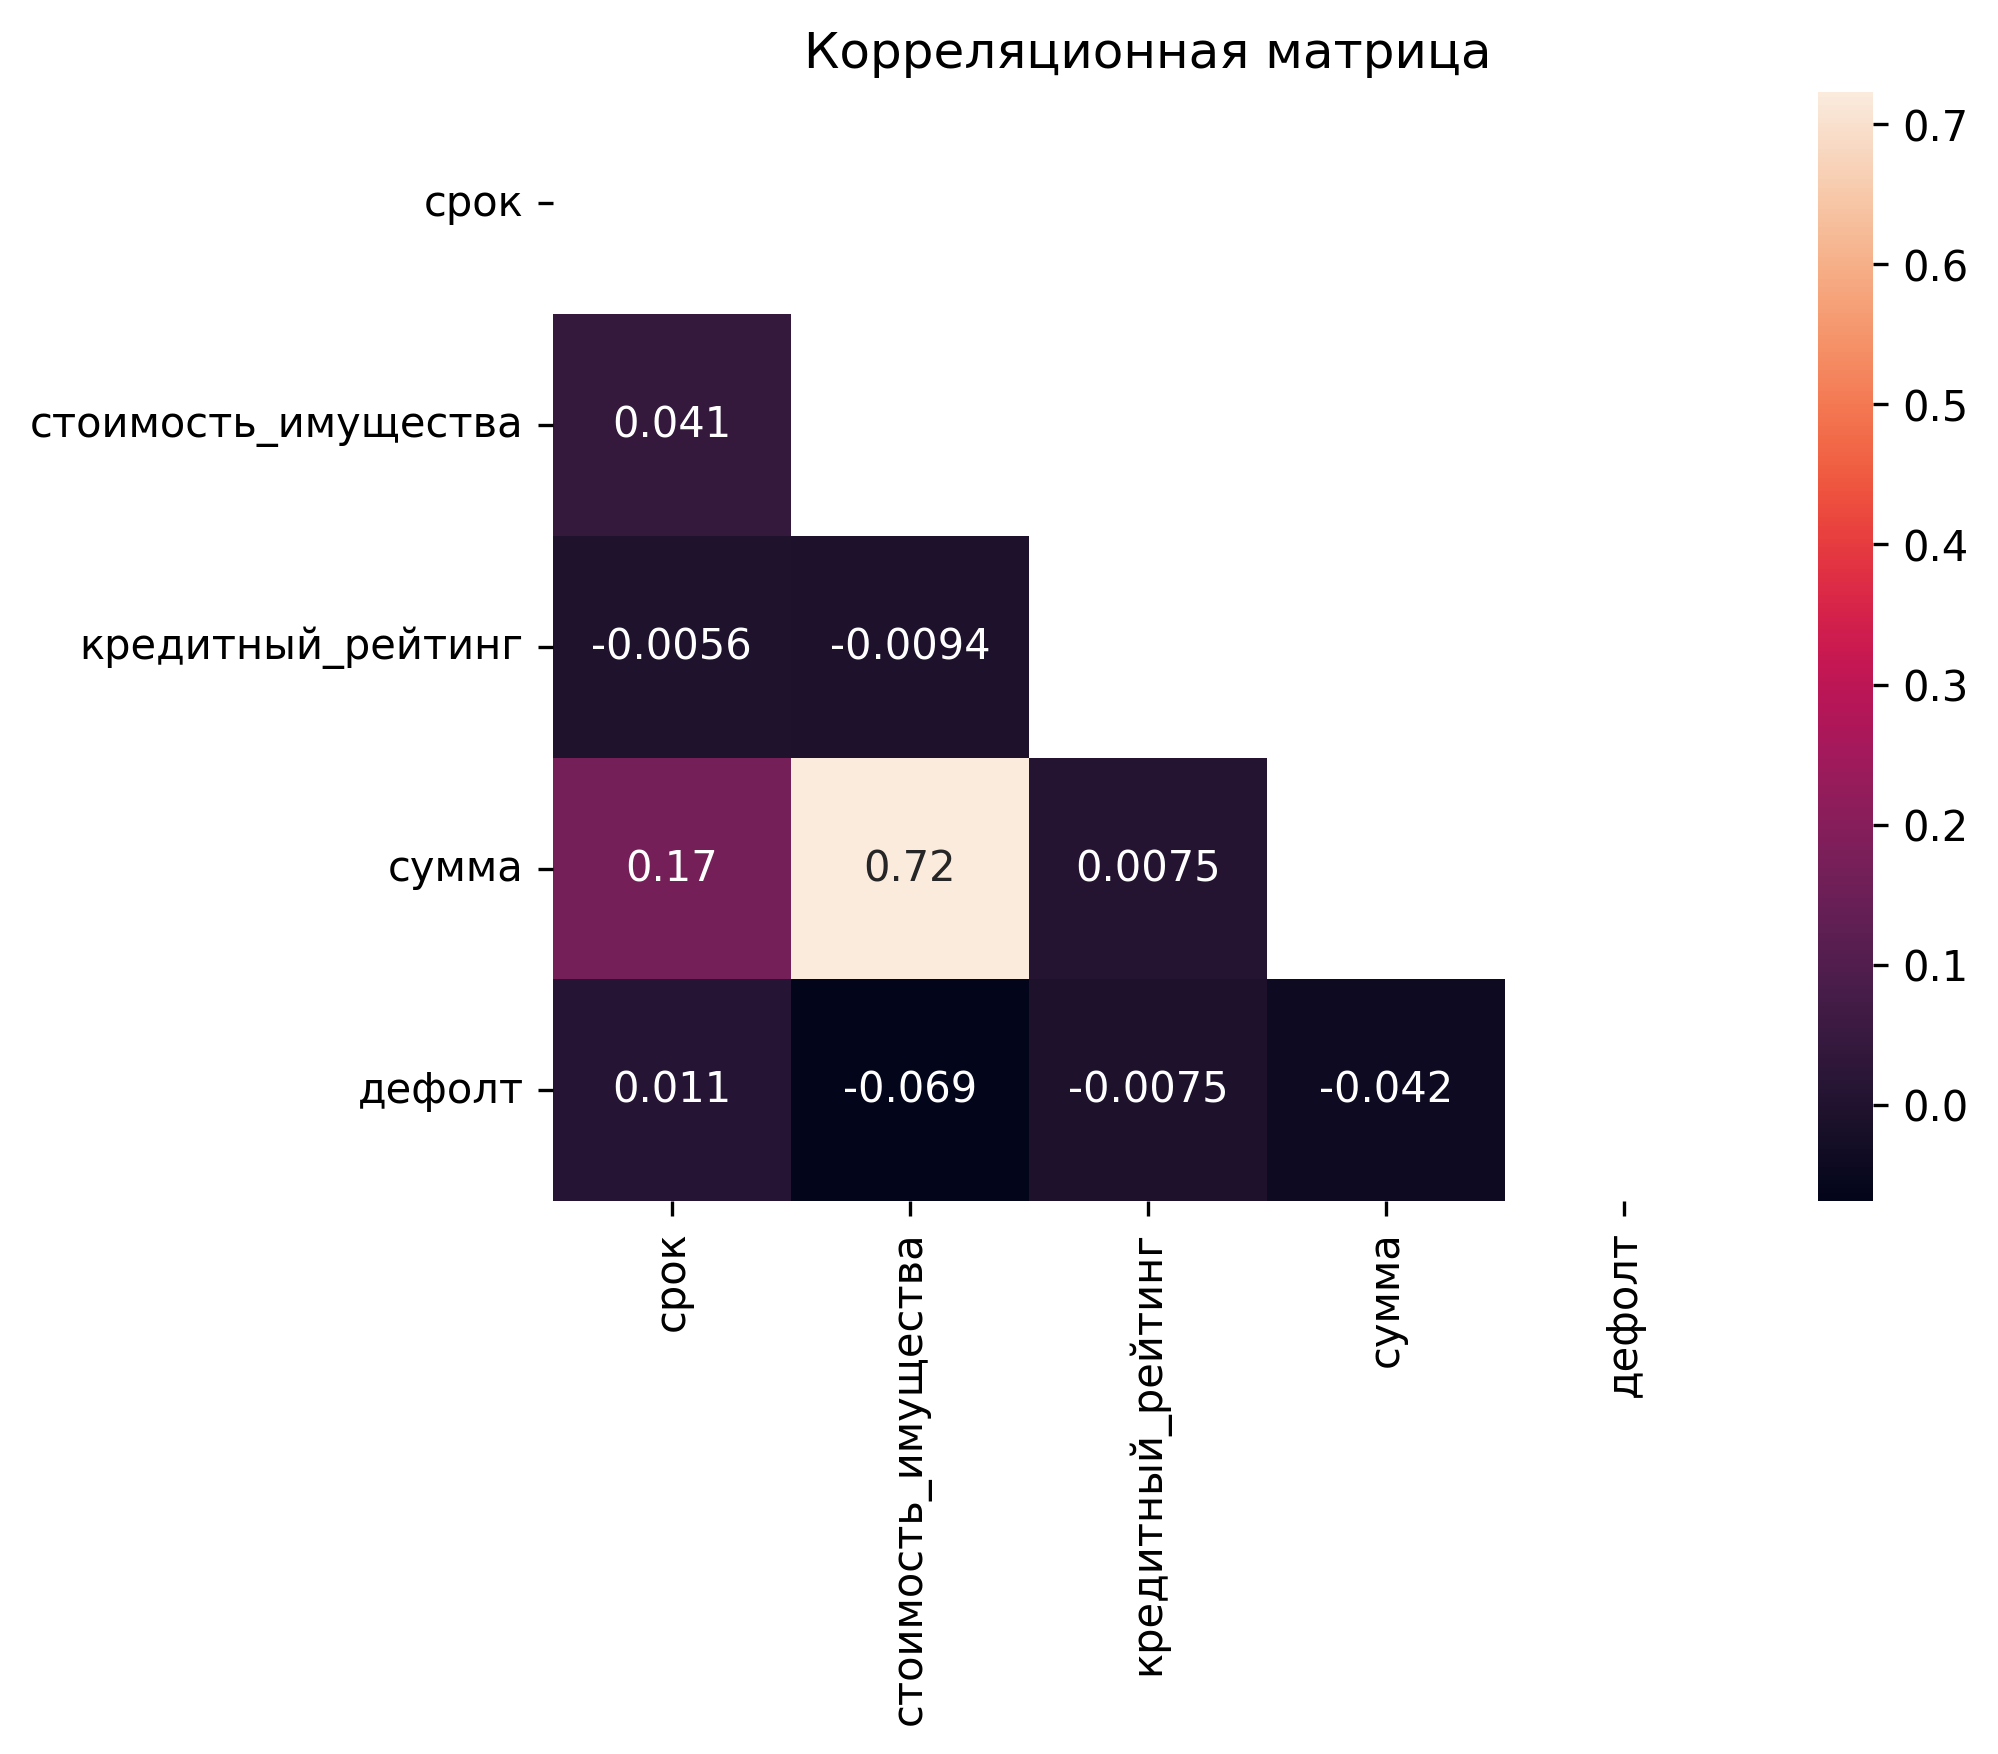

In [15]:
vis.plot_corr(loan_data, numeric_features + ["дефолт"])

### Нормализовать числовые значения

In [29]:
scaler = StandardScaler()
scaler.fit_transform(loan_data[["сумма"]])

array([[-0.94245866],
       [        nan],
       [        nan],
       ...,
       [ 0.25137646],
       [ 1.33668111],
       [ 1.82506821]])

### Пропуски

In [16]:
loan_data.isna().sum()

лимит_нарушен          1538
пол                    4222
тип                    1534
цель                   1558
кредитоспособность     1594
другие_кредиты         1575
бизнес                 1631
сумма                  1586
сбор                      0
срок                   1624
амортизация            1662
только_процент         1565
один_платеж            1604
стоимость_имущества    2210
проживание                0
тип_залога                0
тип_кредита            1660
кредитный_рейтинг      1614
возраст                   8
прямой_залог           1580
дефолт                    0
речь                      0
dtype: int64

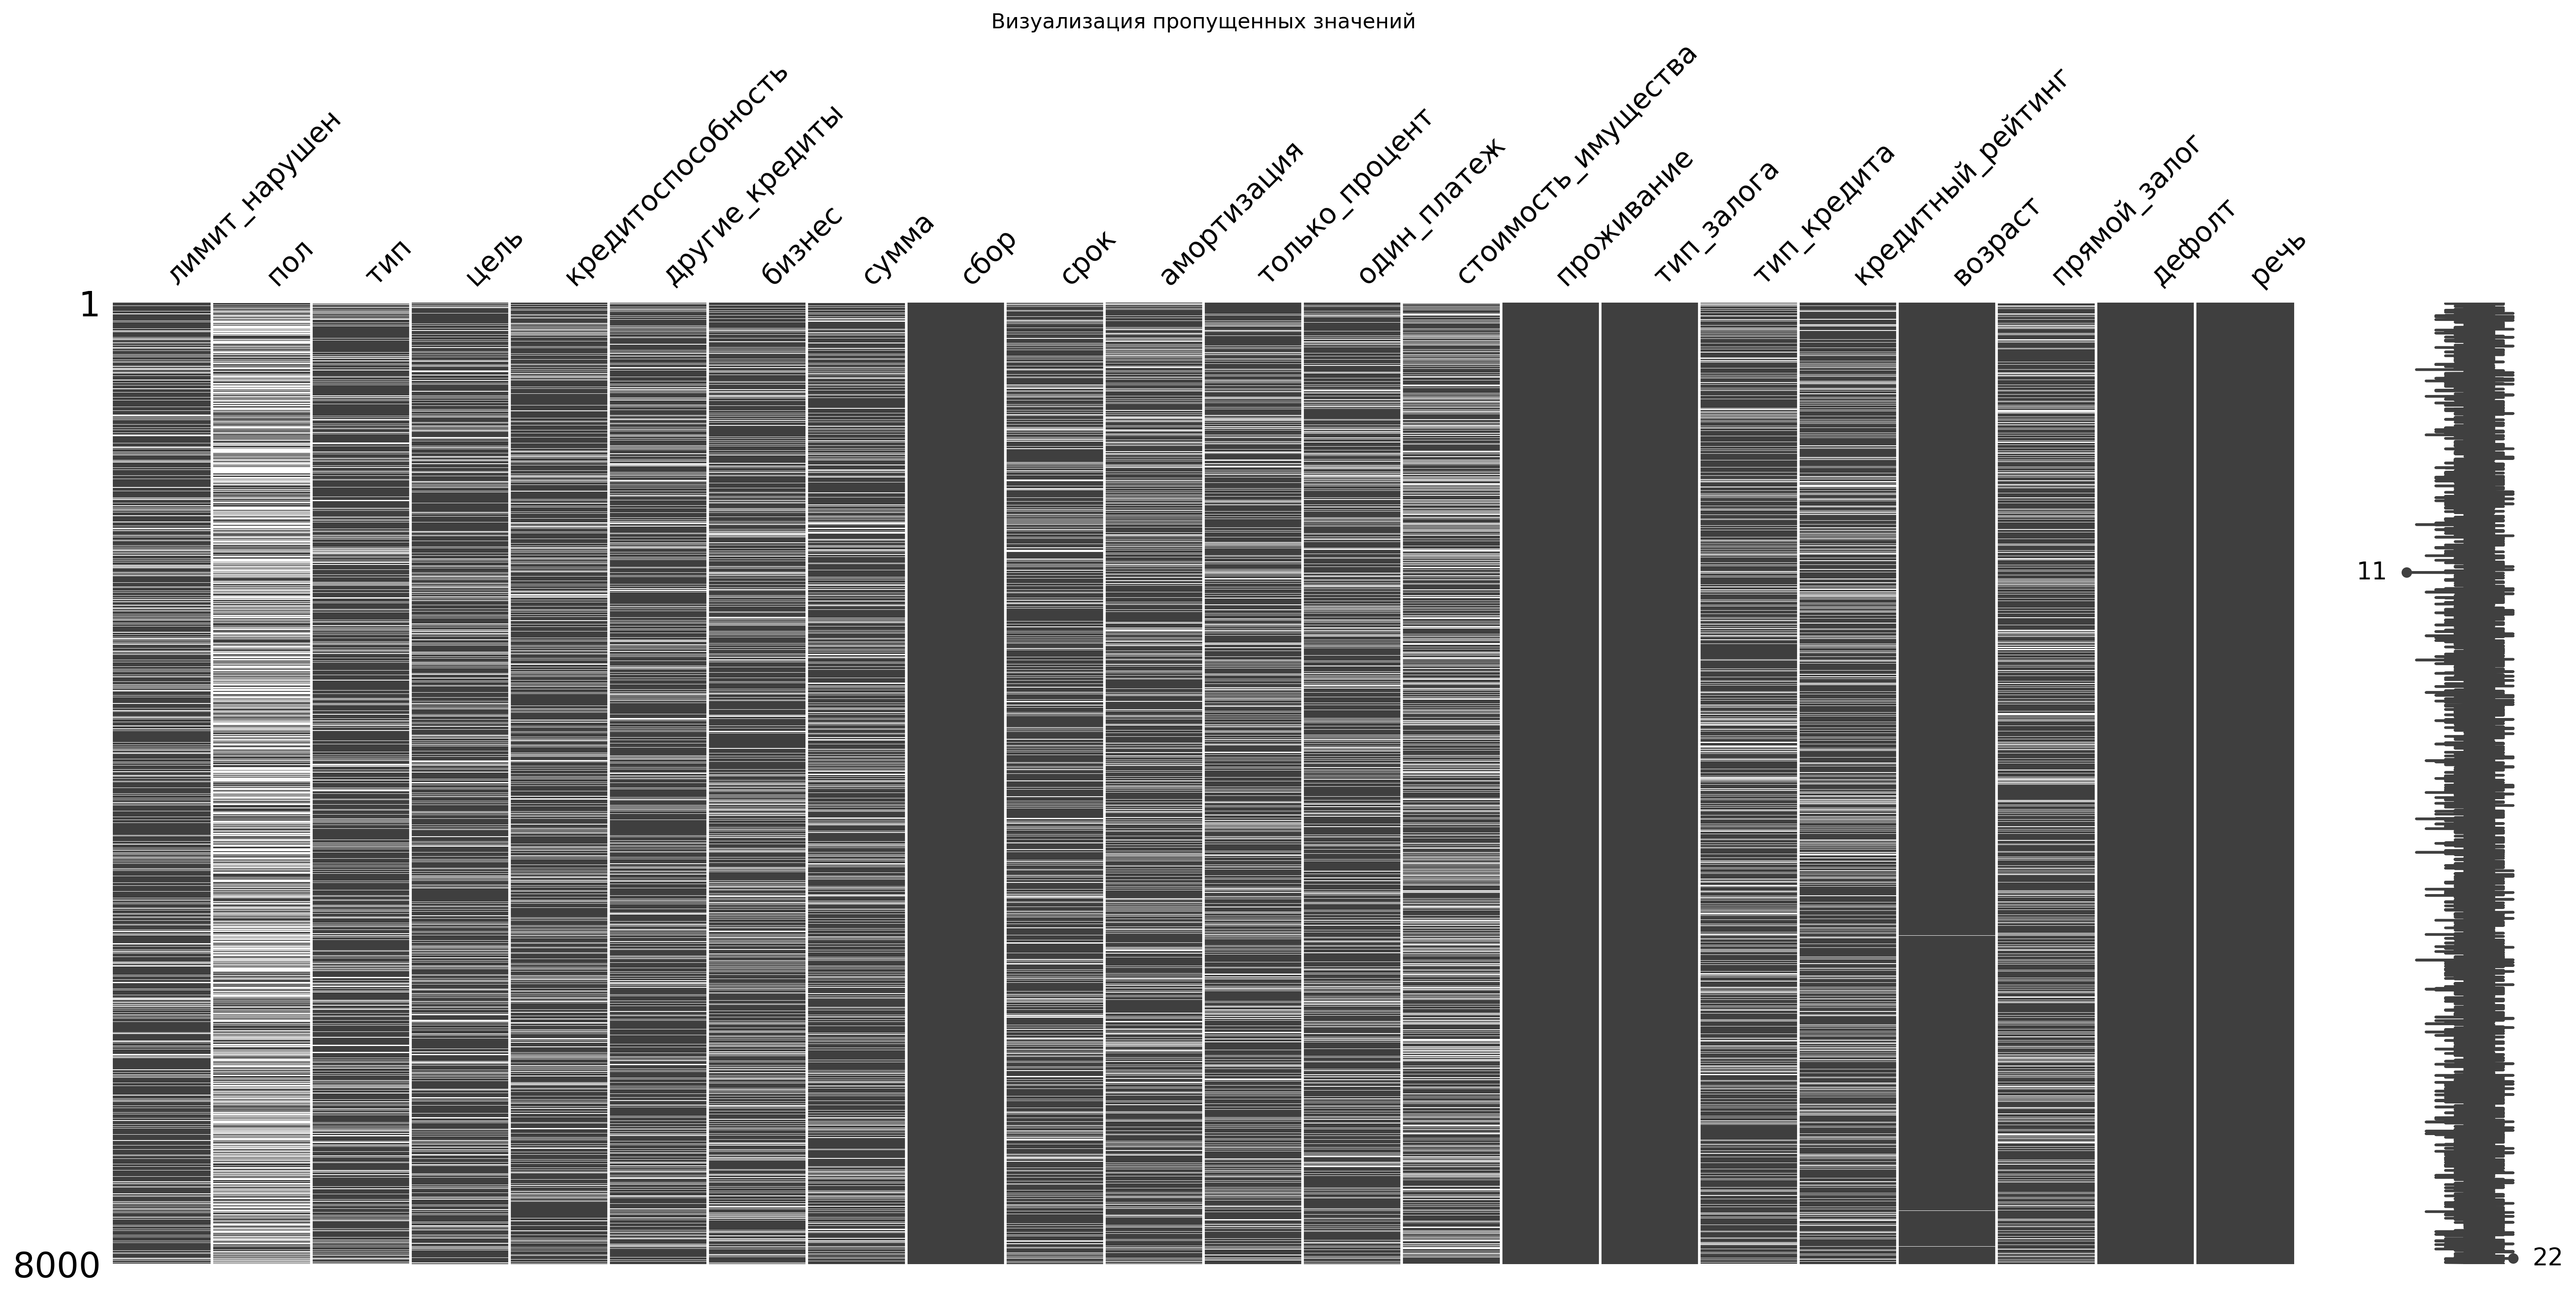

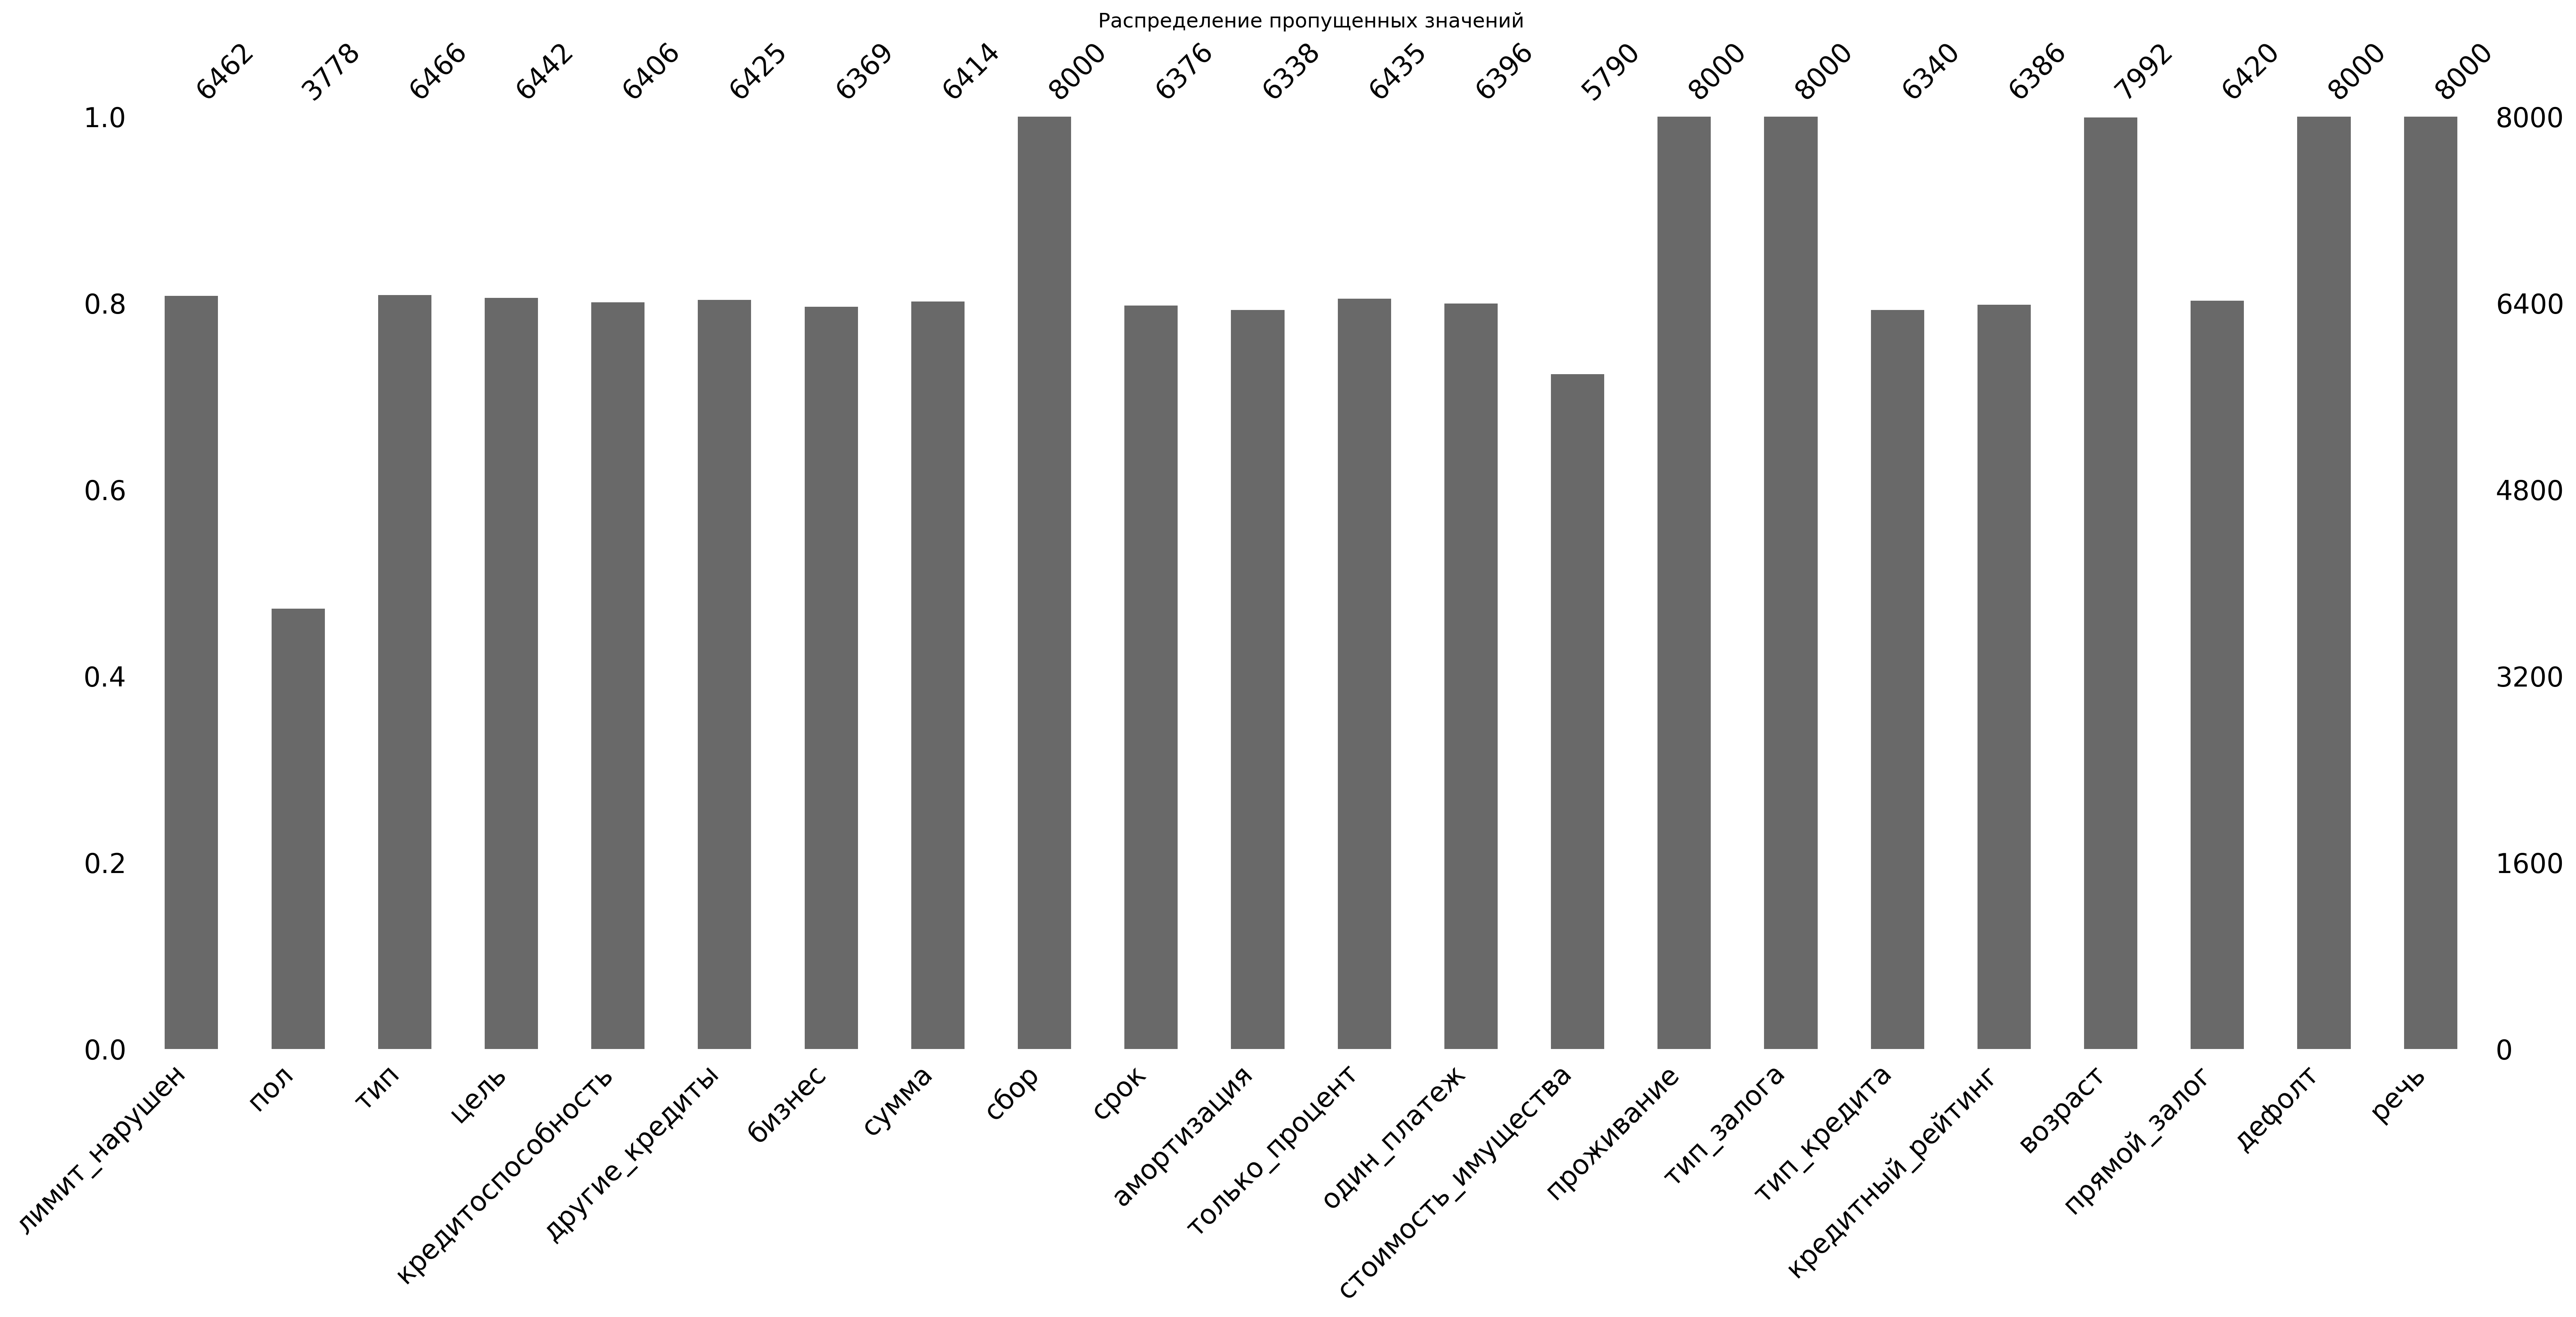

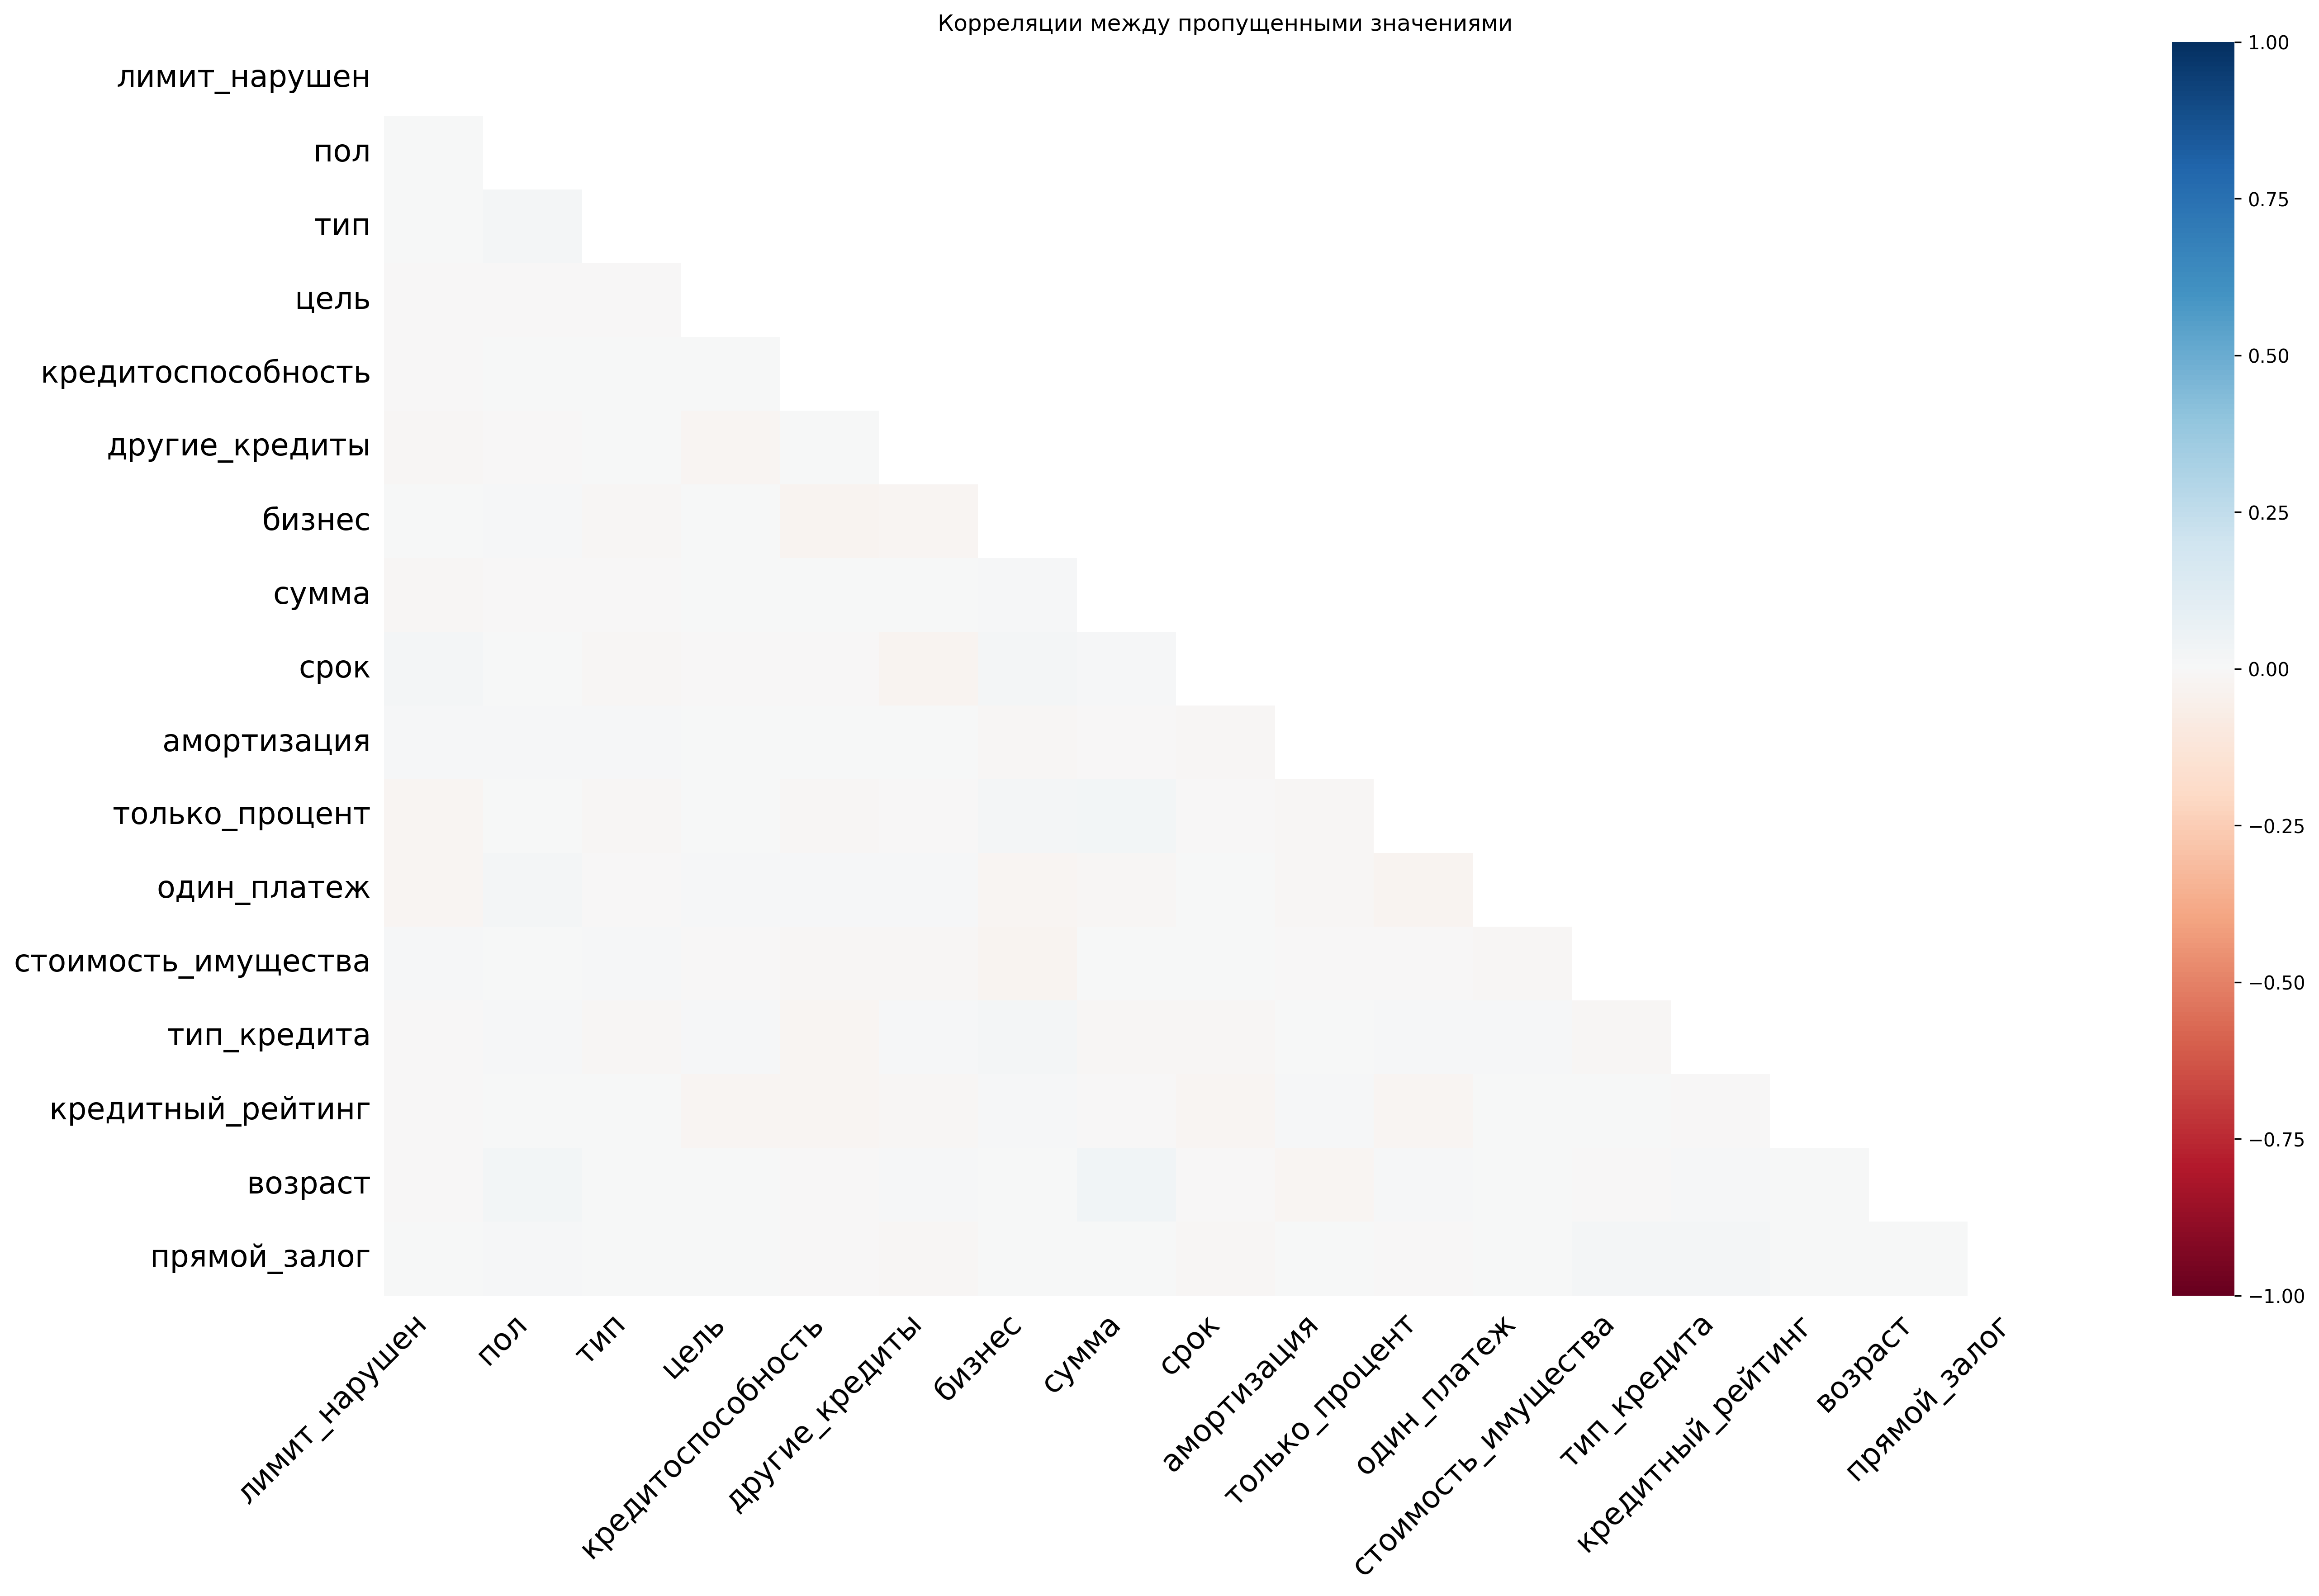

In [30]:
vis.plot_nan(loan_data)

### Заполнить пропуски

In [31]:
imputer = SimpleImputer(strategy="mean")
imputer.fit_transform(loan_data[["сумма"]])

array([[174765.26496798],
       [348441.59798949],
       [348441.59798949],
       ...,
       [394765.26496798],
       [594765.26496798],
       [684765.26496798]])

In [32]:
imputer = SimpleImputer(strategy="median")
imputer.fit_transform(loan_data[["сумма"]])

array([[174765.26496798],
       [314765.26496798],
       [314765.26496798],
       ...,
       [394765.26496798],
       [594765.26496798],
       [684765.26496798]])

In [33]:
imputer = SimpleImputer(strategy="constant", fill_value=-1)
imputer.fit_transform(loan_data[["сумма"]])

array([[ 1.74765265e+05],
       [-1.00000000e+00],
       [-1.00000000e+00],
       ...,
       [ 3.94765265e+05],
       [ 5.94765265e+05],
       [ 6.84765265e+05]])

In [17]:
imputer = KNNImputer(n_neighbors=2)
imputer.fit_transform(loan_data[numeric_features])

array([[2.45885949e+02, 2.44488112e+05, 7.09508335e+02, 1.74765265e+05],
       [3.65885949e+02, 5.54488112e+05, 7.22508335e+02, 2.84765265e+05],
       [3.65885949e+02, 3.64488112e+05, 7.85508335e+02, 2.24765265e+05],
       ...,
       [3.65885949e+02, 6.79488112e+05, 5.84508335e+02, 3.94765265e+05],
       [3.65885949e+02, 6.79488112e+05, 8.73508335e+02, 5.94765265e+05],
       [3.65885949e+02, 3.59488112e+05, 7.54008335e+02, 6.84765265e+05]])

In [19]:
loan_imputed = loan_data.copy()
loan_imputed[numeric_features] = imputer.fit_transform(loan_data[numeric_features])

### Уникальные значения в категориальных столбцах

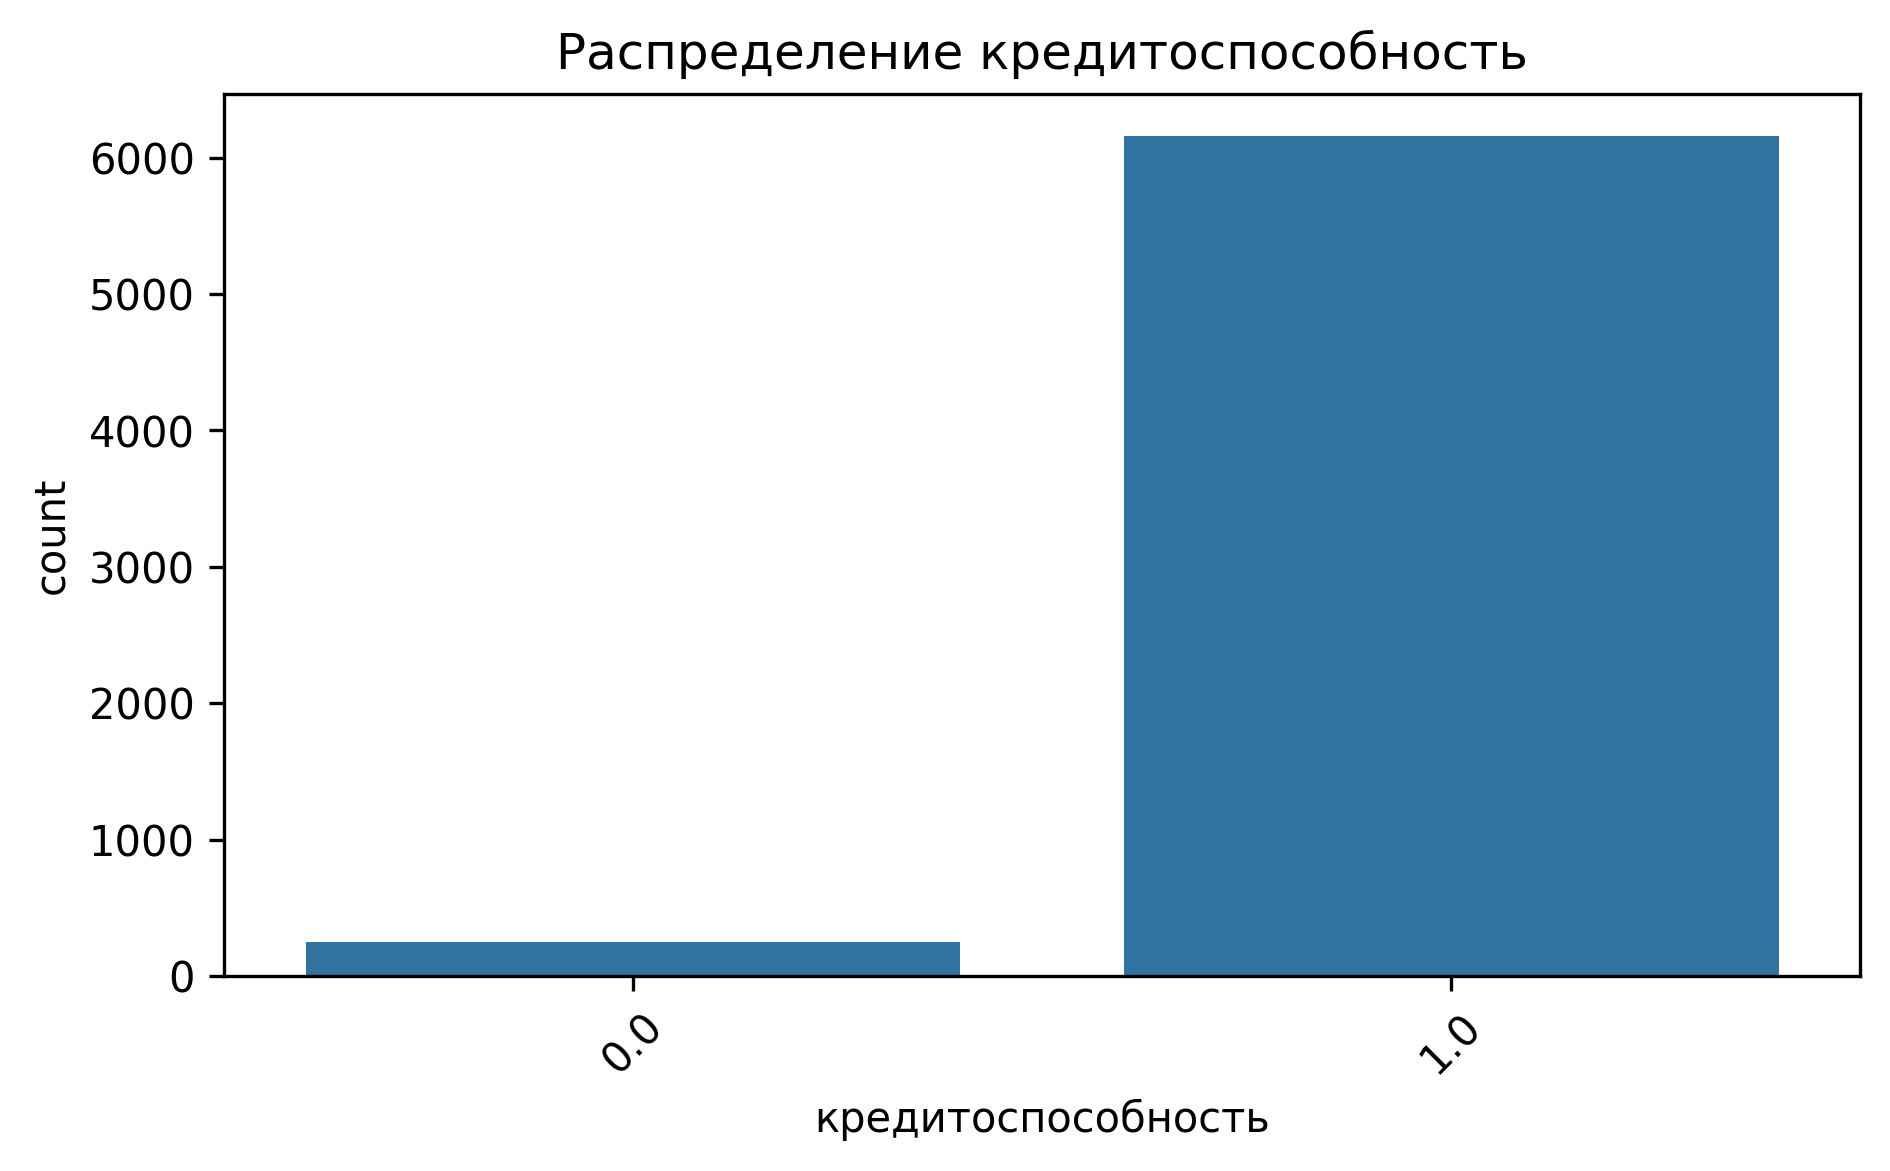

In [34]:
vis.plot_categorical_distributions(loan_data, ["кредитоспособность"])

In [51]:
vis.print_value_counts(loan_data, ["кредитоспособность"])

кредитоспособность
1.0    6157
0.0     249
Name: count, dtype: int64



### Заполнить пропуски в категориальных столбцах

In [14]:
cat_cols = ["кредитоспособность"]
cat_imputer = ColumnTransformer(
    [("imputer", SimpleImputer(strategy="most_frequent"), cat_cols)],
    remainder="passthrough",
)

### Закодировать категориальные признаки при помощи one hot encoding

In [15]:
cat_cols = ["цель"]
cat_encoder = ColumnTransformer(
    [("encoder", OneHotEncoder(), cat_cols)],
    remainder="passthrough",
)

### Закодировать категориальные признаки при помощи label encoding

In [16]:
cat_cols = ["цель"]
cat_encoder = ColumnTransformer(
    [("encoder", OrdinalEncoder(), cat_cols)],
    remainder="passthrough",
)

### Связь категориальных переменных и таргета

In [ ]:
vis.visualize_cat_and_target(loan_data, ["кредитоспособность"])

# Модель

### Обучить модель без разделения

In [7]:
def train_log_reg(data: pd.DataFrame) -> None:
    X, y = modeling.get_xy(data)
    float_cols = X.select_dtypes(exclude=object).columns

    pipe = Pipeline(
        [
            ("feat_select", transforms.FeatSelector(float_cols)),
            ("impute", SimpleImputer(strategy="constant", fill_value=0)),
            ("model", LogisticRegression(random_state=42)),
        ]
    )

    pipe.fit(X, y)
    pred = pipe.predict(X)
    modeling.print_metrics(y_true=y, y_pred=pred)

    return pipe


trained_pipe = train_log_reg(loan_data)

Log reg
Accuracy: 0.812
f1: 0.441


S:\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

### Сделать трансформ на столбцах

In [19]:
scaler = ColumnTransformer(
    [
        ("scaler", StandardScaler(), ["сумма"]),
    ],
    remainder="passthrough",
)

### Разделить выборку на обучающее и тестовое множество

In [52]:
# можно юзать и модифицировать modeling.get_train_test для удобства
df_train, df_test = train_test_split(loan_data, test_size=0.33, random_state=42)

### Сделать отчет о классификации

In [21]:
# Модифицируйте modeling.print_metrics

### Разделить выборку на обучающее и тестовое множество со стратификацией

In [53]:
# можно юзать и модифицировать modeling.get_train_test для удобства
df_train, df_test = train_test_split(loan_data, test_size=0.33, random_state=42, stratify=loan_data[TARGET])

### Обучить модель с разделением

In [54]:
def train_model_with_test(data: pd.DataFrame) -> None:
    df_train, df_test = modeling.get_train_test(data)

    X_train, y_train = modeling.get_xy(df_train)
    X_test, y_test = modeling.get_xy(df_test)

    float_cols = X_train.select_dtypes(exclude=object).columns

    pipe = make_pipeline(
        transforms.FeatSelector(float_cols),
        SimpleImputer(strategy="constant", fill_value=0),
        LogisticRegression(random_state=42),
    )
    pipe.fit(X_train, y_train)

    print("Train")
    pred = pipe.predict(X_train)
    modeling.print_metrics(y_pred=pred, y_true=y_train)
    print()

    print("Test")
    pred = pipe.predict(X_test)
    modeling.print_metrics(y_pred=pred, y_true=y_test)
    print()


train_model_with_test(loan_data)

Train
Log reg
Accuracy: 0.815
f1: 0.426

Test
Log reg
Accuracy: 0.797
f1: 0.410



s:\dev\python\hse-ml-managers\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Обучить модель с настройкой гиперпараметров

In [55]:
def grid_search(data: pd.DataFrame) -> None:
    def get_model(cols: Iterable[str], **kwargs: Any) -> Pipeline:
        return make_pipeline(transforms.FeatSelector(cols), RandomForestClassifier(random_state=42, **kwargs))

    df_train, df_test = modeling.get_train_test(data)
    X_train, y_train = modeling.get_xy(df_train)
    X_test, y_test = modeling.get_xy(df_test)
    float_cols = X_train.select_dtypes(exclude=object).columns

    params = {
        "bootstrap": [True, False],
        # "max_depth": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
        # "max_features": ["auto", "sqrt"],
        # "min_samples_leaf": [1, 2, 4],
        # "min_samples_split": [2, 5, 10],
        # "n_estimators": [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
    }

    best_metric = -np.inf
    best_kwargs: dict[str, Any] | None = None

    for kwargs in tqdm(ParameterGrid(params)):
        cur_pipe = get_model(float_cols, **kwargs)
        cur_pipe.fit(X_train, y_train)
        pred = cur_pipe.predict(X_test)
        metric = f1_score(y_true=y_test, y_pred=pred)
        if metric > best_metric:
            best_metric = metric
            best_kwargs = kwargs

    print(f"Best metric: {best_metric:.3f}")
    print(f"Best kwargs: {best_kwargs}")


grid_search(loan_data)

100%|██████████| 2/2 [00:04<00:00,  2.01s/it]

Best metric: 0.546
Best kwargs: {'bootstrap': False}


### Обучить модель с настройкой гиперпараметров на кросс вале

In [56]:
def grid_search_cv(data: pd.DataFrame) -> None:
    X, y = modeling.get_xy(data)
    float_cols = X.select_dtypes(exclude=object).columns

    params = {
        "randomforestclassifier__bootstrap": [True, False],
        # "randomforestclassifier__max_depth": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
        # "randomforestclassifier__max_features": ["auto", "sqrt"],
        # "randomforestclassifier__min_samples_leaf": [1, 2, 4],
        # "randomforestclassifier__min_samples_split": [2, 5, 10],
        # "randomforestclassifier__n_estimators": [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
    }

    model = make_pipeline(transforms.FeatSelector(float_cols), RandomForestClassifier(random_state=42))
    pipe = GridSearchCV(model, param_grid=params)
    pipe.fit(X, y)
    print("Best params:", pipe.best_params_)
    print("Best score:", pipe.best_score_)


grid_search_cv(loan_data)

Best params: {'randomforestclassifier__bootstrap': True}
Best score: 0.845875


### Обучить модель с настройкой гиперпараметров на кросс вале (для кастомной метрики)

In [57]:
def grid_search_cv_custom(data: pd.DataFrame, n_splits: int = 3) -> None:
    def get_model(cols: Iterable[str], **kwargs: Any) -> Pipeline:
        return make_pipeline(transforms.FeatSelector(cols), RandomForestClassifier(random_state=42, **kwargs))

    X, y = modeling.get_xy(data)
    float_cols = X.select_dtypes(exclude=object).columns
    params = {
        "bootstrap": [True, False],
        # "max_depth": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
        # "max_features": ["auto", "sqrt"],
        # "min_samples_leaf": [1, 2, 4],
        # "min_samples_split": [2, 5, 10],
        # "n_estimators": [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
    }

    best_metric = -np.inf
    best_kwargs: dict[str, Any] | None = None

    folds = list(KFold(n_splits=n_splits).split(X))

    for kwargs in tqdm(ParameterGrid(params)):
        fold_metrics: list[float] = []

        for train_i, test_i in folds:
            X_train, y_train = X.loc[train_i], y.loc[train_i]
            X_test, y_test = X.loc[test_i], y.loc[test_i]

            cur_pipe = get_model(float_cols, **kwargs)
            cur_pipe.fit(X_train, y_train)
            pred = cur_pipe.predict(X_test)
            cur_metric = business.profit(y_true=y_test, y_pred=pred, feats=X_test)
            fold_metrics.append(cur_metric)

        metric = float(np.mean(fold_metrics))
        if metric > best_metric:
            best_metric = metric
            best_kwargs = kwargs

    print(f"Best metric: {best_metric:.3f}")
    print(f"Best kwargs: {best_kwargs}")


grid_search_cv_custom(loan_data)

100%|██████████| 2/2 [00:11<00:00,  5.54s/it]

Best metric: 2641363386406.424
Best kwargs: {'bootstrap': True}


### Разработка текстовых фич

In [58]:
# transforms.TextFeaturesExtractor


def train_text(data: pd.DataFrame) -> None:
    df_train, df_test = modeling.get_train_test(data)

    X_train, y_train = modeling.get_xy(df_train)
    X_test, y_test = modeling.get_xy(df_test)

    cols = list(X_train.select_dtypes(exclude=object).columns)
    cols.append("речь")

    pipe = make_pipeline(
        transforms.FeatSelector(cols),
        transforms.TextFeaturesExtractor(text_feat="речь"),
        SimpleImputer(strategy="mean"),
        StandardScaler(),
        LogisticRegression(random_state=42),
    )
    pipe.fit(X_train, y_train)

    print("Train")
    pred = pipe.predict(X_train)
    modeling.print_metrics(y_pred=pred, y_true=y_train)
    print()

    print("Test")
    pred = pipe.predict(X_test)
    modeling.print_metrics(y_pred=pred, y_true=y_test)
    print()


train_text(loan_data)

Train
Log reg
Accuracy: 0.860
f1: 0.651

Test
Log reg
Accuracy: 0.839
f1: 0.646



# Бизнес

### Спроектировать бизнес-метрику для модели

In [ ]:
# Наша реализация - business.profit

## Оценка на тесте

In [12]:
trained_pipe = train_log_reg(loan_data)
test_pred = trained_pipe.predict(loan_test_data)

Log reg
Accuracy: 0.812
f1: 0.441


S:\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [19]:
y_test_pred = pd.DataFrame({"y_pred": test_pred})
y_test_pred["ID"] = loan_test_data["ID"]
y_test_pred.head(2)

,y_pred,ID
0,0,d61968aa-7fb8-46b2-8573-3d101d3ebe5b
1,0,760116cf-25b4-47aa-9a20-e3baa5fc6d09


In [21]:
y_true_test = pd.read_csv(DATA_TEST_TARGETS_PATH)[["ID", "дефолт"]].rename(columns={"дефолт": "y_true"})
y_true_test.head()

,ID,y_true
0,d61968aa-7fb8-46b2-8573-3d101d3ebe5b,0
1,760116cf-25b4-47aa-9a20-e3baa5fc6d09,0
2,a0a11839-e745-4704-98df-bc3ca0d4de3d,0
3,dce70289-411a-415b-a88b-4cfb708175fd,0
4,4ad07831-8a0a-4ef0-9bdd-fef5496e186a,0


In [24]:
submission = y_test_pred.merge(y_true_test, on="ID")
submission

,y_pred,ID,y_true
0,0,d61968aa-7fb8-46b2-8573-3d101d3ebe5b,0
1,0,760116cf-25b4-47aa-9a20-e3baa5fc6d09,0
2,0,a0a11839-e745-4704-98df-bc3ca0d4de3d,0
3,0,dce70289-411a-415b-a88b-4cfb708175fd,0
4,0,4ad07831-8a0a-4ef0-9bdd-fef5496e186a,0
...,...,...,...
1995,0,dbafd3b1-50ff-4ea7-83f5-dc20d065699a,0
1996,0,70d18e9e-e435-4335-ad4b-2c1392f0ae83,0
1997,0,60d8039e-92aa-41d5-a1e7-2ff58cf50927,0
1998,0,4135b443-2576-4869-9765-f41889939c6e,0


In [28]:
(submission["y_true"] == submission["y_pred"]).mean()

0.8135

In [29]:
business.profit(y_true=submission["y_true"], y_pred=submission["y_pred"], feats=loan_test_data)

1756639131265.3716